In [1]:
# Importing necessary libraries
# !pip install optuna
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from torch.autograd.functional import jacobian as jac
from torch.func import jacfwd, vmap
from csv import writer
import os
import optuna

In [2]:
# if running with Google Colab, enter the right path from your Drive
# otherwise completely comment this cell

# from google.colab import drive
# drive.mount('/content/drive')
# %cd "/content/drive/Othercomputers/My MacBook Pro (1)/LearningEulersElastica/ContinuousNetwork"

In [3]:
from Scripts.GetData import getDataLoaders, loadData
from Scripts.Utils import getBCs
from Scripts.Network import approximate_curve
# from Scripts.Training import trainModel
from Scripts.PlotResults import plotTestResults
from Scripts.SavedParameters import hyperparams

In [4]:
#We do this so Pytorch works in double precision
torch.set_default_dtype(torch.float32)

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [6]:
torch.manual_seed(1)
np.random.seed(1)

In [7]:
percentage_train = input("Choose percentage of training data between 90, 40, 20, and 10: ")
percentage_train = int(percentage_train)/100
percentage_train

Choose percentage of training data between 90, 40, 20, and 10: 80


0.8

In [8]:
# def trainModel(number_elements,device,model,criterion,optimizer,epochs,trainloader,train_with_tangents=False,pde_regularisation=True,soft_bcs_imposition=False):
  
#   torch.manual_seed(1)
#   np.random.seed(1)
  
#   lossVal = 1.
#   epoch = 1
#   scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=45, gamma=0.1)
#   x_eval = np.linspace(0,1,number_elements+1)
    
#   stored_res = 0
#   count = 0
#   cc = 0
#   is_good_loss = False
  
#   while epoch < epochs:
#       losses = []
#       running_loss = 0

#       for i, inp in enumerate(trainloader):
#           q1,q2,v1,v2,s,_,qs,vs = inp
#           q1,q2,v1,v2,s,qs,vs = q1.to(device),q2.to(device),v1.to(device),v2.to(device),s.to(device),qs.to(device),vs.to(device)

#           def closure():
#               optimizer.zero_grad()
#               res_q = model(s,q1,q2,v1,v2)
#               loss = criterion(res_q,qs) + criterion(model.derivative(s,q1,q2,v1,v2),vs) #Comparison only of the qs
#               loss += 1e-2 * torch.mean((torch.linalg.norm(model.derivative(s, q1, q2, v1, v2), ord=2, dim=1)**2-1.)**2)           
#               loss.backward()
#               return loss
            
#           optimizer.step(closure)
#       model.eval();
    
#       with torch.no_grad():
#         res_q = model(s,q1,q2,v1,v2)
#         loss = criterion(res_q,qs)
#         is_good_loss = (loss.item()<8e-6)
#         if epoch == 1:
#           stored_res = loss.item()
#         if epoch == 30:
#           check = (loss.item()>(stored_res * 1e-1))
#           if check and stored_res>1e-2:
#             print("Early stop due to lack of progress")
#             loss = torch.tensor(torch.nan)
#             epoch = epochs + 10
#         print(f'Loss [{epoch+1}](epoch): ', loss.item())
#         if torch.isnan(loss):
#           epoch = epochs + 10
#           break
            
#       model.train();
#       epoch += 1
#       scheduler.step()

#   print('Training Done')
#   print("Loss : ",loss.item())
#   return loss


def trainModel(number_elements,device,model,criterion,optimizer,epochs,trainloader,valloader,train_with_tangents=False,pde_regularisation=True,soft_bcs_imposition=False):
  
    torch.manual_seed(1)
    np.random.seed(1)

    lossVal = 1.
    epoch = 1
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=45, gamma=0.1)
    x_eval = np.linspace(0,1,number_elements+1)

    stored_res = 0
    count = 0
    cc = 0
    is_good_loss = False


    train_losses = []
    val_losses = []

    while epoch <= epochs:
        losses = []
        running_loss = 0

        for i, inp in enumerate(trainloader):
            q1,q2,v1,v2,s,_,qs,vs = inp
            q1,q2,v1,v2,s,qs,vs = q1.to(device),q2.to(device),v1.to(device),v2.to(device),s.to(device),qs.to(device),vs.to(device)


            optimizer.zero_grad()
            res_q = model(s,q1,q2,v1,v2)
            loss = criterion(res_q,qs) + criterion(model.derivative(s,q1,q2,v1,v2),vs) #Comparison only of the qs
            loss += 1e-2 * torch.mean((torch.linalg.norm(model.derivative(s, q1, q2, v1, v2), ord=2, dim=1)**2-1.)**2)           
            loss.backward()

            optimizer.step()
            running_loss += loss.item()
        
        # Calculate average training loss
        train_loss_avg = running_loss / len(trainloader)
        train_losses.append(train_loss_avg)
        
        model.eval();
        
        val_loss = 0
        with torch.no_grad():
            for inp in valloader:
                q1_val, q2_val, v1_val, v2_val, s_val, _, qs_val, vs_val = inp
                q1_val, q2_val, v1_val, v2_val, s_val, qs_val, vs_val = q1_val.to(device), q2_val.to(device), v1_val.to(device), v2_val.to(device), s_val.to(device), qs_val.to(device), vs_val.to(device)

                res_q_val = model(s_val, q1_val, q2_val, v1_val, v2_val)
                val_loss += criterion(res_q_val, qs_val).item()

            # Calculate average validation loss
            val_loss_avg = val_loss / len(valloader)
            val_losses.append(val_loss_avg)

            # Print training and validation losses for each epoch
            print(f"The average loss in epoch {epoch+1} is ",train_loss_avg)            

    #         res_q = model(s,q1,q2,v1,v2)
    #         loss = criterion(res_q,qs)

#             is_good_loss = (loss.item()<8e-6)
#             if epoch == 1:
#                 stored_res = loss.item()
#             if epoch == 30:
#                 check = (loss.item()>(stored_res * 1e-1))
#                 if check and stored_res>1e-2:
#                     print("Early stop due to lack of progress")
#                     loss = torch.tensor(torch.nan)
#                     epoch = epochs + 10
# #             print(f'Loss [{epoch+1}](epoch): ', loss.item())
#             if torch.isnan(loss):
#                 epoch = epochs + 10
#                 break

        model.train();
        epoch += 1
        scheduler.step()

    print('Training Done')
      
    plt.semilogy(np.arange(epochs), train_losses,'r-*',label="training loss",markersize=1)
    plt.semilogy(np.arange(epochs), val_losses,'k-d',label="validation loss",markersize=1)
    plt.xlabel("Epochs")
    plt.ylabel("Loss value")
    plt.legend()
    plt.title("Training and validation losses")
    plt.show();

#     print("Loss : ",loss.item())
    return loss

In [9]:
batch_size = 1024
epochs = 100

In [10]:
num_nodes, trajectories_train, test_traj = loadData()
shuffle_idx_train = np.random.permutation(len(trajectories_train))
trajectories_train = trajectories_train[shuffle_idx_train]
test_traj = test_traj[shuffle_idx_train]

number_samples_train, number_components = trajectories_train.shape
indices_train = np.random.permutation(len(trajectories_train))
trajectories_train = trajectories_train[indices_train]
number_samples_test, _ = test_traj.shape
test_traj = test_traj[indices_train]

number_elements = int(number_components/4)-1
data_train, data_test, data_val, x_train, x_test, y_train, y_test, x_val, y_val, trainloader, testloader, valloader = getDataLoaders(batch_size, number_elements,number_samples_train, number_samples_test,trajectories_train, test_traj, percentage_train)

training_trajectories = np.concatenate((x_train[:,:4],y_train,x_train[:,-4:]),axis=1)
test_trajectories = np.concatenate((x_test[:,:4],y_test,x_test[:,-4:]),axis=1)
val_trajectories = np.concatenate((x_val[:,:4],y_val,x_val[:,-4:]),axis=1)

train :  (789, 8)
val :  (98, 8)
test :  (98, 8)


In [11]:
# def define_model(trial):

#     torch.manual_seed(1)
#     np.random.seed(1)

#     normalize = trial.suggest_categorical("normalize",[True,False])
#     netarch = trial.suggest_categorical("networkarch",[0,1,2])
    
#     if netarch == 0:
#       is_mult = True
#       is_res = False
#     elif netarch == 1:
#       is_mult = False
#       is_res = True
#     else:
#       is_mult = False
#       is_res = False
#     act = trial.suggest_categorical("act",['tanh','sigmoid','sin','swish'])
#     nlayers = trial.suggest_int("n_layers", 3, 8)
#     hidden_nodes = trial.suggest_int("hidden_nodes", 10, 200)
#     model = approximate_curve(normalize, act, nlayers, hidden_nodes, correct_functional=False, is_res=is_res, is_mult=is_mult, both=False)
#     return model

def define_model(trial):

    torch.manual_seed(1)
    np.random.seed(1)

    normalize = True
    netarch = 0
    
    if netarch == 0:
      is_mult = True
      is_res = False
    elif netarch == 1:
      is_mult = False
      is_res = True
    else:
      is_mult = False
      is_res = False
    act = 'tanh'
    nlayers = trial.suggest_int("n_layers", 3, 8)
    hidden_nodes = trial.suggest_int("hidden_nodes", 10, 200)
    model = approximate_curve(normalize, act, nlayers, hidden_nodes, correct_functional=False, is_res=is_res, is_mult=is_mult, both=False)
    return model

In [12]:
# batch_size = 1024
# epochs = 100

In [13]:
from itertools import chain

def flatten_chain(matrix):
    return list(chain.from_iterable(matrix))

q_idx = flatten_chain([[i,i+1] for i in np.arange(0,number_components,4)]) #indices of the qs
qp_idx = flatten_chain([[i+2,i+3] for i in np.arange(0,number_components,4)]) #indices of the q's

In [14]:
def objective(trial):

    torch.manual_seed(1)
    np.random.seed(1)

    model = define_model(trial)
    model.to(device);

#     lr = trial.suggest_float("lr", 1e-3 , 1e-1, log=True)
    lr = 1e-3
    weight_decay = 0
    optimizer = torch.optim.Adam(model.parameters(),lr=lr,weight_decay=weight_decay)
    criterion = nn.MSELoss()
    _, _, _, _, _, _, _, _, _, trainloader, testloader, valloader = getDataLoaders(batch_size, number_elements,number_samples_train, number_samples_test,trajectories_train, test_traj, percentage_train)

    print("Current test with :\n\n")
    for key, value in trial.params.items():
      print("    {}: {}".format(key, value))
    print("\n\n")

    loss = trainModel(number_elements,device,model,criterion,optimizer,epochs,trainloader,valloader,train_with_tangents=False,pde_regularisation=False,soft_bcs_imposition=False)
    val_error = 100
    if not torch.isnan(loss):
        model.eval();

        def eval_model(model,device,s,q1,q2,v1,v2):
            s_ = torch.tensor([[s]],dtype=torch.float32).to(device)
            q1 = torch.from_numpy(q1.astype(np.float32)).reshape(1,-1).to(device)
            q2 = torch.from_numpy(q2.astype(np.float32)).reshape(1,-1).to(device)
            v1 = torch.from_numpy(v1.astype(np.float32)).reshape(1,-1).to(device)
            v2 = torch.from_numpy(v2.astype(np.float32)).reshape(1,-1).to(device)
            return model(s_,q1,q2,v1,v2).detach().cpu().numpy()[0]

        def eval_derivative_model(model,device,s,q1,q2,v1,v2):
            s_ = torch.tensor([[s]],dtype=torch.float32).to(device)
            q1 = torch.from_numpy(q1.astype(np.float32)).reshape(1,-1).to(device)
            q2 = torch.from_numpy(q2.astype(np.float32)).reshape(1,-1).to(device)
            v1 = torch.from_numpy(v1.astype(np.float32)).reshape(1,-1).to(device)
            v2 = torch.from_numpy(v2.astype(np.float32)).reshape(1,-1).to(device)

            return model.derivative(s_,q1,q2,v1,v2).detach().cpu().numpy().reshape(-1)

        bcs = getBCs(val_trajectories)
        q1 = bcs["q1"]
        q2 = bcs["q2"]
        v1 = bcs["v1"]
        v2 = bcs["v2"]

        q1 = torch.from_numpy(bcs["q1"].astype(np.float32)).to(device)
        q2 = torch.from_numpy(bcs["q2"].astype(np.float32)).to(device)
        v1 = torch.from_numpy(bcs["v1"].astype(np.float32)).to(device)
        v2 = torch.from_numpy(bcs["v2"].astype(np.float32)).to(device)

        q_idx = flatten_chain([[i,i+1] for i in np.arange(0,number_components,4)]) #indices of the qs
        qp_idx = flatten_chain([[i+2,i+3] for i in np.arange(0,number_components,4)]) #indices of the q's

        xx = torch.linspace(0,1,number_elements+1).unsqueeze(1).repeat(len(q1),1).to(device)
        one = torch.ones((number_elements+1,1)).to(device)
        q1_augmented = torch.kron(q1,one)
        q2_augmented = torch.kron(q2,one)
        v1_augmented = torch.kron(v1,one)
        v2_augmented = torch.kron(v2,one)

        pred_val_q = model(xx,q1_augmented,q2_augmented,v1_augmented,v2_augmented).reshape(len(q1),-1).detach().cpu().numpy()
        val_error_q = np.mean((pred_val_q-val_trajectories[:,q_idx])**2)
        pred_val_qp = model.derivative(xx,q1_augmented,q2_augmented,v1_augmented,v2_augmented).reshape(len(q1),-1).detach().cpu().numpy()
        val_error_qp = np.mean((pred_val_qp-val_trajectories[:,qp_idx])**2)
        pred_val_all = np.zeros_like(val_trajectories)
        pred_val_all[:, q_idx] = pred_val_q
        pred_val_all[:, qp_idx] = pred_val_qp
        val_error = np.mean((pred_val_all-val_trajectories)**2)

    #Saving the obtained results
    if trial.number == 0:
        labels = []
        for lab, _ in trial.params.items():
            labels.append(str(lab))
        labels.append("Test error")
        with open("SavedResults.csv", "a") as f_object:
            writer_object = writer(f_object)
            writer_object.writerow(labels)
            writer_object.writerow(f"\n\n Percentage of training data: {percentage_train}")
            f_object.close()

    results = []
    for _, value in trial.params.items():
        results.append(str(value))

    results.append(val_error)

    with open("SavedResults.csv", "a") as f_object:
        writer_object = writer(f_object)
        writer_object.writerow(results)
        f_object.close()

    return val_error

Do you want to do hyperparameter test? Type yes or no yes


[I 2024-04-27 18:04:04,494] A new study created in memory with name: Euler Elastica


train :  (789, 8)
val :  (98, 8)
test :  (98, 8)
Current test with :


    n_layers: 7
    hidden_nodes: 125



The average loss in epoch 2 is  0.420529343187809
The average loss in epoch 3 is  0.07052036250631015
The average loss in epoch 4 is  0.051731593596438565
The average loss in epoch 5 is  0.03899574768729508
The average loss in epoch 6 is  0.025558417507757742
The average loss in epoch 7 is  0.02103415709765007
The average loss in epoch 8 is  0.015998273389413953
The average loss in epoch 9 is  0.012635452090762556
The average loss in epoch 10 is  0.020768777273284893
The average loss in epoch 11 is  0.01863355957902968
The average loss in epoch 12 is  0.011308483663015068
The average loss in epoch 13 is  0.010065142375727495
The average loss in epoch 14 is  0.0060285655975652235
The average loss in epoch 15 is  0.006780696683563292
The average loss in epoch 16 is  0.004611997758426393
The average loss in epoch 17 is  0.007622326394387831
The average loss in epoch 18 is  0.005

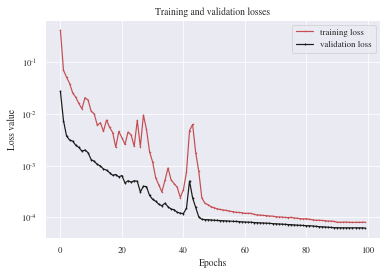

[I 2024-04-27 18:14:47,775] Trial 0 finished with value: 4.209099092735915e-05 and parameters: {'n_layers': 7, 'hidden_nodes': 125}. Best is trial 0 with value: 4.209099092735915e-05.


train :  (789, 8)
val :  (98, 8)
test :  (98, 8)
Current test with :


    n_layers: 8
    hidden_nodes: 111



The average loss in epoch 2 is  0.56655570709457
The average loss in epoch 3 is  0.07479301902155082
The average loss in epoch 4 is  0.05240850414459904
The average loss in epoch 5 is  0.03914117394015193
The average loss in epoch 6 is  0.029236460104584694
The average loss in epoch 7 is  0.021527270165582497
The average loss in epoch 8 is  0.019647363340482116
The average loss in epoch 9 is  0.01703518338035792
The average loss in epoch 10 is  0.015645028984484572
The average loss in epoch 11 is  0.019158578865850966
The average loss in epoch 12 is  0.010178903467021883
The average loss in epoch 13 is  0.007494004365677635
The average loss in epoch 14 is  0.005780808627605438
The average loss in epoch 15 is  0.010636231144114086
The average loss in epoch 16 is  0.007204600784461945
The average loss in epoch 17 is  0.00627039885148406
The average loss in epoch 18 is  0.010328

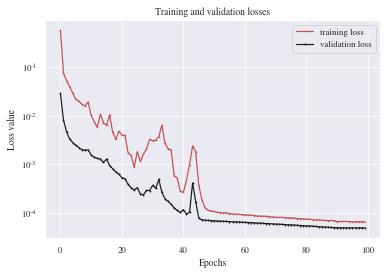

[I 2024-04-27 18:24:41,871] Trial 1 finished with value: 3.4108523432164216e-05 and parameters: {'n_layers': 8, 'hidden_nodes': 111}. Best is trial 1 with value: 3.4108523432164216e-05.


train :  (789, 8)
val :  (98, 8)
test :  (98, 8)
Current test with :


    n_layers: 8
    hidden_nodes: 151



The average loss in epoch 2 is  0.42731255386024714
The average loss in epoch 3 is  0.07017683687930305
The average loss in epoch 4 is  0.04447685608950754
The average loss in epoch 5 is  0.029411116847768426
The average loss in epoch 6 is  0.018616617502023775
The average loss in epoch 7 is  0.013744289404712617
The average loss in epoch 8 is  0.012535317742731422
The average loss in epoch 9 is  0.014926668101300796
The average loss in epoch 10 is  0.010943257133476436
The average loss in epoch 11 is  0.0164479335071519
The average loss in epoch 12 is  0.010348707204684615
The average loss in epoch 13 is  0.0072245648674046
The average loss in epoch 14 is  0.008552895917091519
The average loss in epoch 15 is  0.005331909817565854
The average loss in epoch 16 is  0.00455558390240185
The average loss in epoch 17 is  0.0028682013313906887
The average loss in epoch 18 is  0.0086

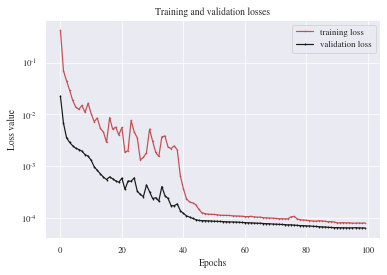

[I 2024-04-27 18:38:13,599] Trial 2 finished with value: 4.9021203775202547e-05 and parameters: {'n_layers': 8, 'hidden_nodes': 151}. Best is trial 1 with value: 3.4108523432164216e-05.


train :  (789, 8)
val :  (98, 8)
test :  (98, 8)
Current test with :


    n_layers: 6
    hidden_nodes: 147



The average loss in epoch 2 is  0.4319782940049966
The average loss in epoch 3 is  0.07139440191288789
The average loss in epoch 4 is  0.05265503376722336
The average loss in epoch 5 is  0.03694936089838544
The average loss in epoch 6 is  0.024348940700292587
The average loss in epoch 7 is  0.018036565161310136
The average loss in epoch 8 is  0.015160922814781467
The average loss in epoch 9 is  0.01544319283372412
The average loss in epoch 10 is  0.016257244666727882
The average loss in epoch 11 is  0.014485040427340815
The average loss in epoch 12 is  0.006868369508689891
The average loss in epoch 13 is  0.004630212545938169
The average loss in epoch 14 is  0.002770942863814222
The average loss in epoch 15 is  0.005187184384946401
The average loss in epoch 16 is  0.00329642435341763
The average loss in epoch 17 is  0.0043236180548168095
The average loss in epoch 18 is  0.008

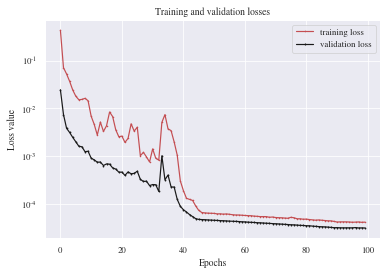

[I 2024-04-27 18:49:00,415] Trial 3 finished with value: 2.7677498428435863e-05 and parameters: {'n_layers': 6, 'hidden_nodes': 147}. Best is trial 3 with value: 2.7677498428435863e-05.


train :  (789, 8)
val :  (98, 8)
test :  (98, 8)
Current test with :


    n_layers: 5
    hidden_nodes: 14



The average loss in epoch 2 is  1.8873651325702667
The average loss in epoch 3 is  0.83809315909942
The average loss in epoch 4 is  0.3198090133567651
The average loss in epoch 5 is  0.18581167111794153
The average loss in epoch 6 is  0.11703427198032539
The average loss in epoch 7 is  0.0870447475463152
The average loss in epoch 8 is  0.07782018401970466
The average loss in epoch 9 is  0.07248182191203038
The average loss in epoch 10 is  0.07026392687112093
The average loss in epoch 11 is  0.06547169325252374
The average loss in epoch 12 is  0.06224696043257912
The average loss in epoch 13 is  0.05674779290954272
The average loss in epoch 14 is  0.05104890869309505
The average loss in epoch 15 is  0.04488877486437559
The average loss in epoch 16 is  0.03927496323982874
The average loss in epoch 17 is  0.035646702628582716
The average loss in epoch 18 is  0.034821781407420836


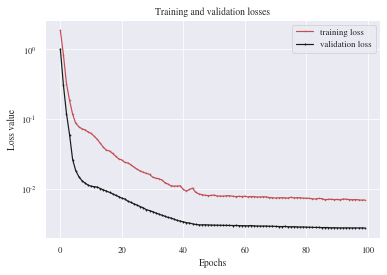

[I 2024-04-27 18:53:10,713] Trial 4 finished with value: 0.0027279288605175822 and parameters: {'n_layers': 5, 'hidden_nodes': 14}. Best is trial 3 with value: 2.7677498428435863e-05.


train :  (789, 8)
val :  (98, 8)
test :  (98, 8)
Current test with :


    n_layers: 5
    hidden_nodes: 21



The average loss in epoch 2 is  1.1181898439923923
The average loss in epoch 3 is  0.35110357714196044
The average loss in epoch 4 is  0.14153113216161728
The average loss in epoch 5 is  0.08512331265956163
The average loss in epoch 6 is  0.07383990784486134
The average loss in epoch 7 is  0.06649281596764922
The average loss in epoch 8 is  0.058683633959541716
The average loss in epoch 9 is  0.04735343297943473
The average loss in epoch 10 is  0.04030402253071467
The average loss in epoch 11 is  0.029662690435846645
The average loss in epoch 12 is  0.025194738681117695
The average loss in epoch 13 is  0.023048176352555554
The average loss in epoch 14 is  0.02055142478396495
The average loss in epoch 15 is  0.02028057638866206
The average loss in epoch 16 is  0.016977841616608202
The average loss in epoch 17 is  0.01574058101202051
The average loss in epoch 18 is  0.0144642523

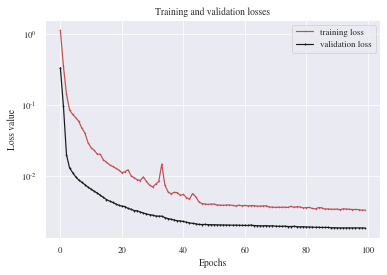

[I 2024-04-27 18:57:37,829] Trial 5 finished with value: 0.001466864103537993 and parameters: {'n_layers': 5, 'hidden_nodes': 21}. Best is trial 3 with value: 2.7677498428435863e-05.


train :  (789, 8)
val :  (98, 8)
test :  (98, 8)
Current test with :


    n_layers: 6
    hidden_nodes: 156



The average loss in epoch 2 is  0.44551233761012554
The average loss in epoch 3 is  0.06849109924708803
The average loss in epoch 4 is  0.046674994907031454
The average loss in epoch 5 is  0.02689286961685866
The average loss in epoch 6 is  0.02121140439218531
The average loss in epoch 7 is  0.01334723694405208
The average loss in epoch 8 is  0.01206923338274161
The average loss in epoch 9 is  0.014836157322861254
The average loss in epoch 10 is  0.01592896576039493
The average loss in epoch 11 is  0.013204956252593547
The average loss in epoch 12 is  0.007603534691346188
The average loss in epoch 13 is  0.006190425153666486
The average loss in epoch 14 is  0.004978411947377026
The average loss in epoch 15 is  0.006203484964013721
The average loss in epoch 16 is  0.0037082029642382017
The average loss in epoch 17 is  0.004486654167218755
The average loss in epoch 18 is  0.005

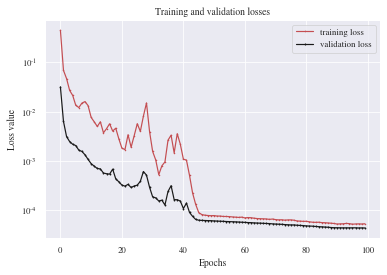

[I 2024-04-27 19:08:46,116] Trial 6 finished with value: 2.769843376014738e-05 and parameters: {'n_layers': 6, 'hidden_nodes': 156}. Best is trial 3 with value: 2.7677498428435863e-05.


train :  (789, 8)
val :  (98, 8)
test :  (98, 8)
Current test with :


    n_layers: 5
    hidden_nodes: 96



The average loss in epoch 2 is  0.5503101327146093
The average loss in epoch 3 is  0.07712549529969692
The average loss in epoch 4 is  0.05846298517038425
The average loss in epoch 5 is  0.04615043321003517
The average loss in epoch 6 is  0.029649324249476194
The average loss in epoch 7 is  0.020747756818309426
The average loss in epoch 8 is  0.016263099076847237
The average loss in epoch 9 is  0.013721226675746342
The average loss in epoch 10 is  0.010526876372750849
The average loss in epoch 11 is  0.014684020483400673
The average loss in epoch 12 is  0.007528985016203175
The average loss in epoch 13 is  0.006560072943102568
The average loss in epoch 14 is  0.005375461303628981
The average loss in epoch 15 is  0.004497388668823987
The average loss in epoch 16 is  0.004780454949165384
The average loss in epoch 17 is  0.004022016073577106
The average loss in epoch 18 is  0.003

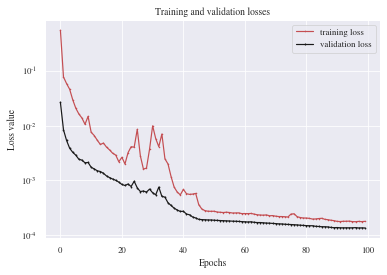

[I 2024-04-27 19:15:33,127] Trial 7 finished with value: 0.00011384984054735192 and parameters: {'n_layers': 5, 'hidden_nodes': 96}. Best is trial 3 with value: 2.7677498428435863e-05.


train :  (789, 8)
val :  (98, 8)
test :  (98, 8)
Current test with :


    n_layers: 5
    hidden_nodes: 198



The average loss in epoch 2 is  0.38719716885437566
The average loss in epoch 3 is  0.0628908200499912
The average loss in epoch 4 is  0.043647515665118895
The average loss in epoch 5 is  0.026780636903519433
The average loss in epoch 6 is  0.019776987998435896
The average loss in epoch 7 is  0.014809468722281357
The average loss in epoch 8 is  0.009963199030607939
The average loss in epoch 9 is  0.00803821194373692
The average loss in epoch 10 is  0.02223656283846746
The average loss in epoch 11 is  0.013783549424260855
The average loss in epoch 12 is  0.007807955184640984
The average loss in epoch 13 is  0.006502029117352019
The average loss in epoch 14 is  0.0040702128123181565
The average loss in epoch 15 is  0.004509559240735446
The average loss in epoch 16 is  0.004127317787303279
The average loss in epoch 17 is  0.0027346287436860925
The average loss in epoch 18 is  0.

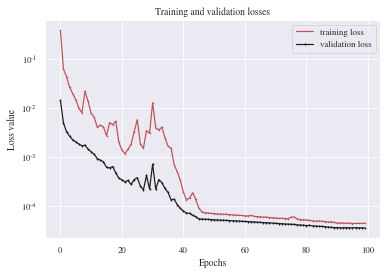

[I 2024-04-27 19:28:10,560] Trial 8 finished with value: 2.8332986837436125e-05 and parameters: {'n_layers': 5, 'hidden_nodes': 198}. Best is trial 3 with value: 2.7677498428435863e-05.


train :  (789, 8)
val :  (98, 8)
test :  (98, 8)
Current test with :


    n_layers: 7
    hidden_nodes: 32



The average loss in epoch 2 is  1.2502776496112347
The average loss in epoch 3 is  0.2610676071296136
The average loss in epoch 4 is  0.09870135287443797
The average loss in epoch 5 is  0.0696080142321686
The average loss in epoch 6 is  0.061313973274081945
The average loss in epoch 7 is  0.05317984397212664
The average loss in epoch 8 is  0.04431915655732155
The average loss in epoch 9 is  0.03690807040159901
The average loss in epoch 10 is  0.02927784761413932
The average loss in epoch 11 is  0.025183785473927855
The average loss in epoch 12 is  0.017842709319666028
The average loss in epoch 13 is  0.013767654929930965
The average loss in epoch 14 is  0.011006638252486786
The average loss in epoch 15 is  0.009537936265890798
The average loss in epoch 16 is  0.010000958456657827
The average loss in epoch 17 is  0.007910072609471777
The average loss in epoch 18 is  0.007177957

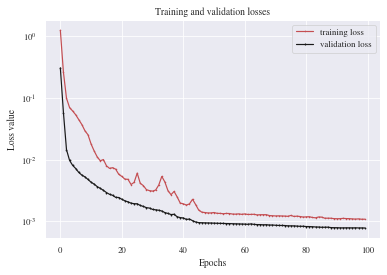

[I 2024-04-27 19:33:42,938] Trial 9 finished with value: 0.000581865369350045 and parameters: {'n_layers': 7, 'hidden_nodes': 32}. Best is trial 3 with value: 2.7677498428435863e-05.


train :  (789, 8)
val :  (98, 8)
test :  (98, 8)
Current test with :


    n_layers: 3
    hidden_nodes: 72



The average loss in epoch 2 is  0.7809649979074796
The average loss in epoch 3 is  0.09382103104144335
The average loss in epoch 4 is  0.06161813313762347
The average loss in epoch 5 is  0.04995595136036476
The average loss in epoch 6 is  0.04283871610338489
The average loss in epoch 7 is  0.03577633916089932
The average loss in epoch 8 is  0.029384877998381853
The average loss in epoch 9 is  0.022187077595541876
The average loss in epoch 10 is  0.01732096596000095
The average loss in epoch 11 is  0.013507314181576172
The average loss in epoch 12 is  0.009214189427439123
The average loss in epoch 13 is  0.007821592114244899
The average loss in epoch 14 is  0.007051557709928602
The average loss in epoch 15 is  0.006455888040363789
The average loss in epoch 16 is  0.0063807541349281864
The average loss in epoch 17 is  0.00986517247899125
The average loss in epoch 18 is  0.008491

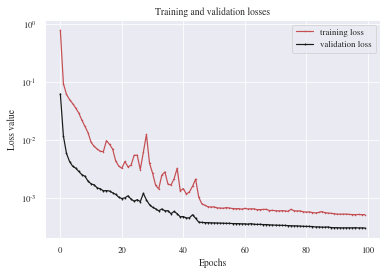

[I 2024-04-27 19:38:37,622] Trial 10 finished with value: 0.00030204987650868256 and parameters: {'n_layers': 3, 'hidden_nodes': 72}. Best is trial 3 with value: 2.7677498428435863e-05.


train :  (789, 8)
val :  (98, 8)
test :  (98, 8)
Current test with :


    n_layers: 6
    hidden_nodes: 173



The average loss in epoch 2 is  0.36238476168364286
The average loss in epoch 3 is  0.06391865697999795
The average loss in epoch 4 is  0.04429988904545704
The average loss in epoch 5 is  0.026405687211081386
The average loss in epoch 6 is  0.017935001795801025
The average loss in epoch 7 is  0.012192578831066688
The average loss in epoch 8 is  0.013060057264131805
The average loss in epoch 9 is  0.011316959590961536
The average loss in epoch 10 is  0.010794525170543542
The average loss in epoch 11 is  0.010006648177901903
The average loss in epoch 12 is  0.005979461517805855
The average loss in epoch 13 is  0.0031756416865391657
The average loss in epoch 14 is  0.003630480127564321
The average loss in epoch 15 is  0.0041298160795122385
The average loss in epoch 16 is  0.002521916491483959
The average loss in epoch 17 is  0.0025766114607298127
The average loss in epoch 18 is 

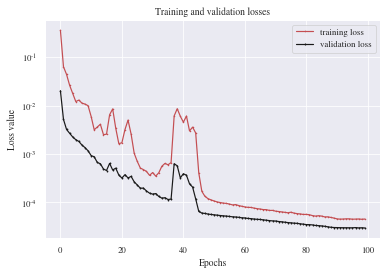

[I 2024-04-27 19:51:11,277] Trial 11 finished with value: 3.953704194208295e-05 and parameters: {'n_layers': 6, 'hidden_nodes': 173}. Best is trial 3 with value: 2.7677498428435863e-05.


train :  (789, 8)
val :  (98, 8)
test :  (98, 8)
Current test with :


    n_layers: 3
    hidden_nodes: 148



The average loss in epoch 2 is  0.38612822194894153
The average loss in epoch 3 is  0.06804441505422194
The average loss in epoch 4 is  0.04909723252058029
The average loss in epoch 5 is  0.03713541322698196
The average loss in epoch 6 is  0.025498072616755962
The average loss in epoch 7 is  0.01606948518504699
The average loss in epoch 8 is  0.016475458318988483
The average loss in epoch 9 is  0.010125994061430296
The average loss in epoch 10 is  0.017017894696133833
The average loss in epoch 11 is  0.011139770989151051
The average loss in epoch 12 is  0.0057417026643330855
The average loss in epoch 13 is  0.008840328160052499
The average loss in epoch 14 is  0.0060413487469001366
The average loss in epoch 15 is  0.005654396372847259
The average loss in epoch 16 is  0.00510559761702704
The average loss in epoch 17 is  0.003947034550947137
The average loss in epoch 18 is  0.0

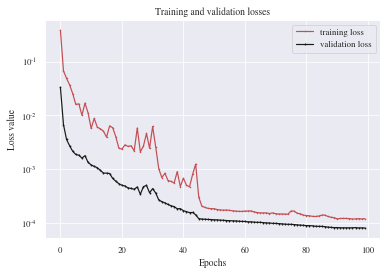

[I 2024-04-27 19:58:38,147] Trial 12 finished with value: 8.067347450822494e-05 and parameters: {'n_layers': 3, 'hidden_nodes': 148}. Best is trial 3 with value: 2.7677498428435863e-05.


train :  (789, 8)
val :  (98, 8)
test :  (98, 8)
Current test with :


    n_layers: 6
    hidden_nodes: 168



The average loss in epoch 2 is  0.3659117314964533
The average loss in epoch 3 is  0.06520321608210604
The average loss in epoch 4 is  0.04264392276915411
The average loss in epoch 5 is  0.02527374471537769
The average loss in epoch 6 is  0.01922471433257063
The average loss in epoch 7 is  0.01732877913552026
The average loss in epoch 8 is  0.011231088389952978
The average loss in epoch 9 is  0.009025047261578342
The average loss in epoch 10 is  0.014631593289474646
The average loss in epoch 11 is  0.011091658069441715
The average loss in epoch 12 is  0.005863060049402217
The average loss in epoch 13 is  0.0059223726275376976
The average loss in epoch 14 is  0.006387435811726998
The average loss in epoch 15 is  0.005281781321779515
The average loss in epoch 16 is  0.0028627744807939357
The average loss in epoch 17 is  0.0027337811722342544
The average loss in epoch 18 is  0.0

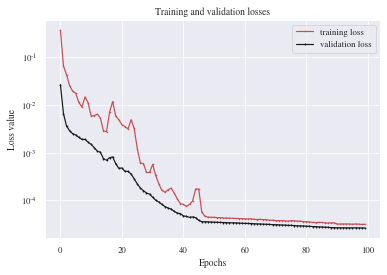

[I 2024-04-27 20:10:31,162] Trial 13 finished with value: 2.1065163592541287e-05 and parameters: {'n_layers': 6, 'hidden_nodes': 168}. Best is trial 13 with value: 2.1065163592541287e-05.


train :  (789, 8)
val :  (98, 8)
test :  (98, 8)
Current test with :


    n_layers: 4
    hidden_nodes: 197



The average loss in epoch 2 is  0.3641556814933817
The average loss in epoch 3 is  0.06196499848738313
The average loss in epoch 4 is  0.044569945273300014
The average loss in epoch 5 is  0.030970383047436673
The average loss in epoch 6 is  0.022310521531229217
The average loss in epoch 7 is  0.016788466523091
The average loss in epoch 8 is  0.01363815770794948
The average loss in epoch 9 is  0.010086588095873594
The average loss in epoch 10 is  0.015132208975652853
The average loss in epoch 11 is  0.012821913328176985
The average loss in epoch 12 is  0.005623852067704623
The average loss in epoch 13 is  0.00481032210518606
The average loss in epoch 14 is  0.003961215038240577
The average loss in epoch 15 is  0.003940172988222912
The average loss in epoch 16 is  0.002904781732164944
The average loss in epoch 17 is  0.002097512381927421
The average loss in epoch 18 is  0.00238

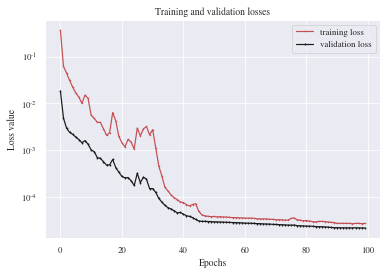

[I 2024-04-27 20:22:12,324] Trial 14 finished with value: 2.4454920790898525e-05 and parameters: {'n_layers': 4, 'hidden_nodes': 197}. Best is trial 13 with value: 2.1065163592541287e-05.


train :  (789, 8)
val :  (98, 8)
test :  (98, 8)
Current test with :


    n_layers: 4
    hidden_nodes: 191



The average loss in epoch 2 is  0.36076564838488895
The average loss in epoch 3 is  0.06288913761576016
The average loss in epoch 4 is  0.044759172635773815
The average loss in epoch 5 is  0.029949729175617296
The average loss in epoch 6 is  0.021588808468853433
The average loss in epoch 7 is  0.01930475316476077
The average loss in epoch 8 is  0.016996148663262527
The average loss in epoch 9 is  0.01479583908803761
The average loss in epoch 10 is  0.012921478502297154
The average loss in epoch 11 is  0.017622286764283974
The average loss in epoch 12 is  0.008256919410390159
The average loss in epoch 13 is  0.009899717522785068
The average loss in epoch 14 is  0.007686227889886747
The average loss in epoch 15 is  0.007143277539095531
The average loss in epoch 16 is  0.0034931071277242154
The average loss in epoch 17 is  0.0033805768956275037
The average loss in epoch 18 is  0

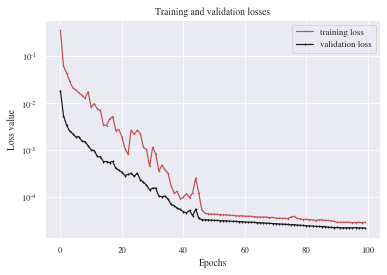

[I 2024-04-27 20:34:57,027] Trial 15 finished with value: 2.5283701203074034e-05 and parameters: {'n_layers': 4, 'hidden_nodes': 191}. Best is trial 13 with value: 2.1065163592541287e-05.


train :  (789, 8)
val :  (98, 8)
test :  (98, 8)
Current test with :


    n_layers: 4
    hidden_nodes: 177



The average loss in epoch 2 is  0.37548863670478266
The average loss in epoch 3 is  0.0628605008435746
The average loss in epoch 4 is  0.04407346807420254
The average loss in epoch 5 is  0.028587782057002187
The average loss in epoch 6 is  0.020245200217080612
The average loss in epoch 7 is  0.022608907738079626
The average loss in epoch 8 is  0.013952636528604975
The average loss in epoch 9 is  0.011183567034701506
The average loss in epoch 10 is  0.01825474974854539
The average loss in epoch 11 is  0.013971268160579106
The average loss in epoch 12 is  0.009055378497578204
The average loss in epoch 13 is  0.006904005975229666
The average loss in epoch 14 is  0.0054609629441984
The average loss in epoch 15 is  0.0046853921182143194
The average loss in epoch 16 is  0.004176427823646615
The average loss in epoch 17 is  0.003866066806949675
The average loss in epoch 18 is  0.007

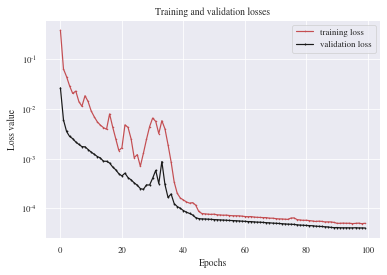

[I 2024-04-27 20:47:08,704] Trial 16 finished with value: 3.562175820035182e-05 and parameters: {'n_layers': 4, 'hidden_nodes': 177}. Best is trial 13 with value: 2.1065163592541287e-05.


train :  (789, 8)
val :  (98, 8)
test :  (98, 8)
Current test with :


    n_layers: 4
    hidden_nodes: 175



The average loss in epoch 2 is  0.37883488554507494
The average loss in epoch 3 is  0.06320330748955409
The average loss in epoch 4 is  0.046375727746635675
The average loss in epoch 5 is  0.033362241073821984
The average loss in epoch 6 is  0.021154980757273734
The average loss in epoch 7 is  0.014645469142124057
The average loss in epoch 8 is  0.01409886870533228
The average loss in epoch 9 is  0.007709575137899567
The average loss in epoch 10 is  0.009037603624165058
The average loss in epoch 11 is  0.017622862205219764
The average loss in epoch 12 is  0.010088225768413395
The average loss in epoch 13 is  0.008513496839441359
The average loss in epoch 14 is  0.006910445750690997
The average loss in epoch 15 is  0.006071585007399942
The average loss in epoch 16 is  0.00441778539485919
The average loss in epoch 17 is  0.0031538663897663355
The average loss in epoch 18 is  0.

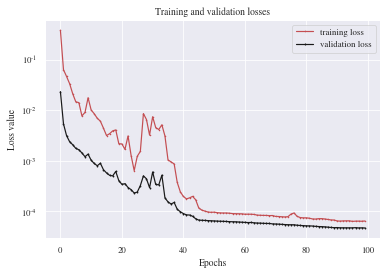

[I 2024-04-27 20:57:14,748] Trial 17 finished with value: 4.998295565052544e-05 and parameters: {'n_layers': 4, 'hidden_nodes': 175}. Best is trial 13 with value: 2.1065163592541287e-05.


train :  (789, 8)
val :  (98, 8)
test :  (98, 8)
Current test with :


    n_layers: 7
    hidden_nodes: 66



The average loss in epoch 2 is  0.8880204235514005
The average loss in epoch 3 is  0.11193632831176122
The average loss in epoch 4 is  0.06479588197544217
The average loss in epoch 5 is  0.05234691717972358
The average loss in epoch 6 is  0.04063747737867137
The average loss in epoch 7 is  0.031510588712990284
The average loss in epoch 8 is  0.023030267485106986
The average loss in epoch 9 is  0.018507626373320818
The average loss in epoch 10 is  0.0188995359155039
The average loss in epoch 11 is  0.012782977661117911
The average loss in epoch 12 is  0.008323547158700725
The average loss in epoch 13 is  0.008414821039574841
The average loss in epoch 14 is  0.006810951027243088
The average loss in epoch 15 is  0.006254236272070557
The average loss in epoch 16 is  0.007628345105331391
The average loss in epoch 17 is  0.007185445962628971
The average loss in epoch 18 is  0.007662

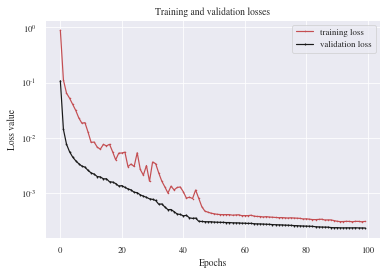

[I 2024-04-27 21:04:02,394] Trial 18 finished with value: 0.00017659332443043863 and parameters: {'n_layers': 7, 'hidden_nodes': 66}. Best is trial 13 with value: 2.1065163592541287e-05.


train :  (789, 8)
val :  (98, 8)
test :  (98, 8)
Current test with :


    n_layers: 4
    hidden_nodes: 128



The average loss in epoch 2 is  0.5151483540733656
The average loss in epoch 3 is  0.07446435807893674
The average loss in epoch 4 is  0.05382854910567403
The average loss in epoch 5 is  0.03930767408261696
The average loss in epoch 6 is  0.025615358414749306
The average loss in epoch 7 is  0.020744730291577678
The average loss in epoch 8 is  0.014998496316062907
The average loss in epoch 9 is  0.015947369392961264
The average loss in epoch 10 is  0.010356423018189767
The average loss in epoch 11 is  0.010117926945288977
The average loss in epoch 12 is  0.004517572961049154
The average loss in epoch 13 is  0.004269111794807638
The average loss in epoch 14 is  0.003506071244676908
The average loss in epoch 15 is  0.00329275059630163
The average loss in epoch 16 is  0.003063573172160735
The average loss in epoch 17 is  0.005397993333948155
The average loss in epoch 18 is  0.004

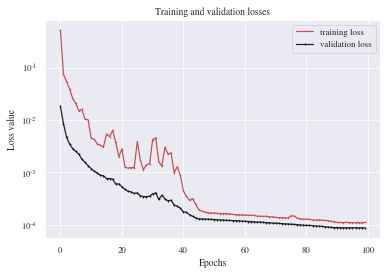

[I 2024-04-27 21:11:27,045] Trial 19 finished with value: 7.90968853627331e-05 and parameters: {'n_layers': 4, 'hidden_nodes': 128}. Best is trial 13 with value: 2.1065163592541287e-05.


train :  (789, 8)
val :  (98, 8)
test :  (98, 8)
Current test with :


    n_layers: 3
    hidden_nodes: 199



The average loss in epoch 2 is  0.4325710354993741
The average loss in epoch 3 is  0.06463840696960688
The average loss in epoch 4 is  0.04621338456248244
The average loss in epoch 5 is  0.03486891843688985
The average loss in epoch 6 is  0.025612914469093084
The average loss in epoch 7 is  0.017327711451798677
The average loss in epoch 8 is  0.01504826673772186
The average loss in epoch 9 is  0.014376379704723755
The average loss in epoch 10 is  0.015189479338005185
The average loss in epoch 11 is  0.01699556615979721
The average loss in epoch 12 is  0.007366290005544822
The average loss in epoch 13 is  0.006254819929987813
The average loss in epoch 14 is  0.005643439197835202
The average loss in epoch 15 is  0.0065926154687379794
The average loss in epoch 16 is  0.003903361279905463
The average loss in epoch 17 is  0.00499606648615251
The average loss in epoch 18 is  0.0084

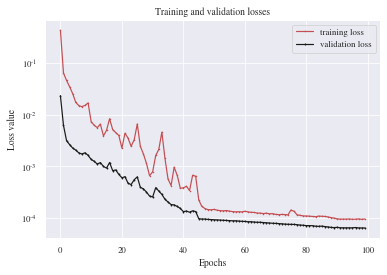

[I 2024-04-27 21:21:10,025] Trial 20 finished with value: 7.701874277120264e-05 and parameters: {'n_layers': 3, 'hidden_nodes': 199}. Best is trial 13 with value: 2.1065163592541287e-05.


train :  (789, 8)
val :  (98, 8)
test :  (98, 8)
Current test with :


    n_layers: 4
    hidden_nodes: 183



The average loss in epoch 2 is  0.3869174874077241
The average loss in epoch 3 is  0.06669716102381547
The average loss in epoch 4 is  0.0457219408514599
The average loss in epoch 5 is  0.027455885506545503
The average loss in epoch 6 is  0.01837091047006349
The average loss in epoch 7 is  0.018242730332228046
The average loss in epoch 8 is  0.011948623636271805
The average loss in epoch 9 is  0.00822216470260173
The average loss in epoch 10 is  0.011542705392154554
The average loss in epoch 11 is  0.008381421512846524
The average loss in epoch 12 is  0.006019907654263079
The average loss in epoch 13 is  0.006977974786423147
The average loss in epoch 14 is  0.002926166242104955
The average loss in epoch 15 is  0.003679338871734217
The average loss in epoch 16 is  0.0029382586556797228
The average loss in epoch 17 is  0.0024076826084638014
The average loss in epoch 18 is  0.00

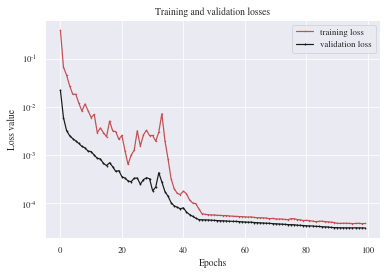

[I 2024-04-27 21:31:24,874] Trial 21 finished with value: 3.0395942355720512e-05 and parameters: {'n_layers': 4, 'hidden_nodes': 183}. Best is trial 13 with value: 2.1065163592541287e-05.


train :  (789, 8)
val :  (98, 8)
test :  (98, 8)
Current test with :


    n_layers: 4
    hidden_nodes: 193



The average loss in epoch 2 is  0.3667110825578372
The average loss in epoch 3 is  0.06075200826550523
The average loss in epoch 4 is  0.04153270126941303
The average loss in epoch 5 is  0.027698096508781116
The average loss in epoch 6 is  0.017241495739047725
The average loss in epoch 7 is  0.018618198616119724
The average loss in epoch 8 is  0.011868447298184037
The average loss in epoch 9 is  0.010949523964275917
The average loss in epoch 10 is  0.010844296911576142
The average loss in epoch 11 is  0.02022606146056205
The average loss in epoch 12 is  0.009122805456475666
The average loss in epoch 13 is  0.006955952014929305
The average loss in epoch 14 is  0.004430360548819105
The average loss in epoch 15 is  0.004150055145146325
The average loss in epoch 16 is  0.004265273474932958
The average loss in epoch 17 is  0.00300655981603389
The average loss in epoch 18 is  0.005

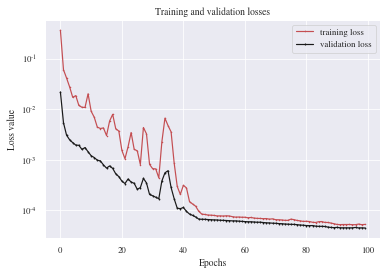

[I 2024-04-27 21:44:09,891] Trial 22 finished with value: 4.4116365119004945e-05 and parameters: {'n_layers': 4, 'hidden_nodes': 193}. Best is trial 13 with value: 2.1065163592541287e-05.


train :  (789, 8)
val :  (98, 8)
test :  (98, 8)
Current test with :


    n_layers: 6
    hidden_nodes: 163



The average loss in epoch 2 is  0.39819836616516113
The average loss in epoch 3 is  0.0666492801780502
The average loss in epoch 4 is  0.04537217582886418
The average loss in epoch 5 is  0.028021577668065827
The average loss in epoch 6 is  0.01757382993431141
The average loss in epoch 7 is  0.013742716827740272
The average loss in epoch 8 is  0.011313658556900918
The average loss in epoch 9 is  0.00877014206101497
The average loss in epoch 10 is  0.010383337697324654
The average loss in epoch 11 is  0.011422820796724409
The average loss in epoch 12 is  0.005747563360879819
The average loss in epoch 13 is  0.003718027990544215
The average loss in epoch 14 is  0.003134406123232717
The average loss in epoch 15 is  0.003113297173210109
The average loss in epoch 16 is  0.002892855021248882
The average loss in epoch 17 is  0.007984630841140946
The average loss in epoch 18 is  0.005

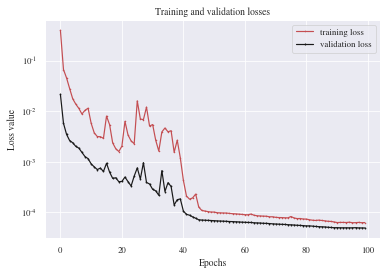

[I 2024-04-27 21:58:20,767] Trial 23 finished with value: 3.968941542142672e-05 and parameters: {'n_layers': 6, 'hidden_nodes': 163}. Best is trial 13 with value: 2.1065163592541287e-05.


train :  (789, 8)
val :  (98, 8)
test :  (98, 8)
Current test with :


    n_layers: 5
    hidden_nodes: 133



The average loss in epoch 2 is  0.40277819242328405
The average loss in epoch 3 is  0.07155508470411102
The average loss in epoch 4 is  0.05095921844864885
The average loss in epoch 5 is  0.03424878457250694
The average loss in epoch 6 is  0.02264039059324811
The average loss in epoch 7 is  0.016553988311594974
The average loss in epoch 8 is  0.010382995727316787
The average loss in epoch 9 is  0.013796933460980654
The average loss in epoch 10 is  0.015219888805101315
The average loss in epoch 11 is  0.011412806517910212
The average loss in epoch 12 is  0.006047394029640903
The average loss in epoch 13 is  0.007821987945741663
The average loss in epoch 14 is  0.0055525073742804425
The average loss in epoch 15 is  0.007041544246021658
The average loss in epoch 16 is  0.004198443891558175
The average loss in epoch 17 is  0.003319786318267385
The average loss in epoch 18 is  0.0

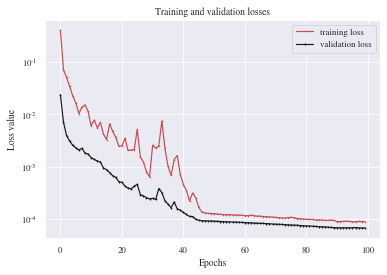

[I 2024-04-27 22:08:55,987] Trial 24 finished with value: 5.0459422225299204e-05 and parameters: {'n_layers': 5, 'hidden_nodes': 133}. Best is trial 13 with value: 2.1065163592541287e-05.


train :  (789, 8)
val :  (98, 8)
test :  (98, 8)
Current test with :


    n_layers: 3
    hidden_nodes: 186



The average loss in epoch 2 is  0.41958491162707406
The average loss in epoch 3 is  0.06503574534629782
The average loss in epoch 4 is  0.048050964095940195
The average loss in epoch 5 is  0.03675433325891694
The average loss in epoch 6 is  0.02711452745522062
The average loss in epoch 7 is  0.02141478715930134
The average loss in epoch 8 is  0.01592617967010786
The average loss in epoch 9 is  0.014328418532386422
The average loss in epoch 10 is  0.011812337635395428
The average loss in epoch 11 is  0.01726449013222009
The average loss in epoch 12 is  0.00852539095406731
The average loss in epoch 13 is  0.007170001714257523
The average loss in epoch 14 is  0.004103196348296478
The average loss in epoch 15 is  0.004765710201657687
The average loss in epoch 16 is  0.004099750774912536
The average loss in epoch 17 is  0.004110152716748416
The average loss in epoch 18 is  0.00365

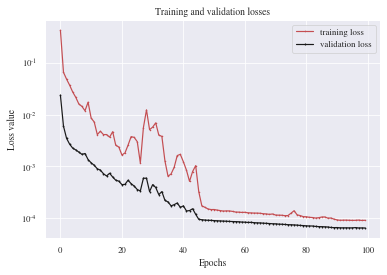

[I 2024-04-27 22:18:44,625] Trial 25 finished with value: 6.255444451507649e-05 and parameters: {'n_layers': 3, 'hidden_nodes': 186}. Best is trial 13 with value: 2.1065163592541287e-05.


train :  (789, 8)
val :  (98, 8)
test :  (98, 8)
Current test with :


    n_layers: 4
    hidden_nodes: 167



The average loss in epoch 2 is  0.4225498701756199
The average loss in epoch 3 is  0.06872883501152198
The average loss in epoch 4 is  0.0504355455438296
The average loss in epoch 5 is  0.036375556606799364
The average loss in epoch 6 is  0.02376262688388427
The average loss in epoch 7 is  0.015734862458581727
The average loss in epoch 8 is  0.01584769746599098
The average loss in epoch 9 is  0.01566994081561764
The average loss in epoch 10 is  0.01318697379125903
The average loss in epoch 11 is  0.013609432072068254
The average loss in epoch 12 is  0.007042465188230078
The average loss in epoch 13 is  0.008034401010566702
The average loss in epoch 14 is  0.003888862110519161
The average loss in epoch 15 is  0.003221859321153412
The average loss in epoch 16 is  0.0034660607683084286
The average loss in epoch 17 is  0.0028757662463855618
The average loss in epoch 18 is  0.0063

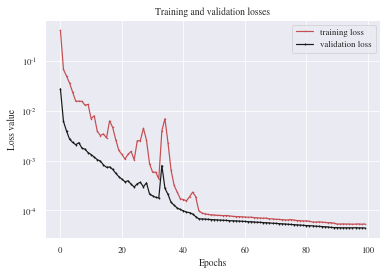

[I 2024-04-27 22:30:57,060] Trial 26 finished with value: 3.911581431364069e-05 and parameters: {'n_layers': 4, 'hidden_nodes': 167}. Best is trial 13 with value: 2.1065163592541287e-05.


train :  (789, 8)
val :  (98, 8)
test :  (98, 8)
Current test with :


    n_layers: 5
    hidden_nodes: 199



The average loss in epoch 2 is  0.35281152464449406
The average loss in epoch 3 is  0.062064267694950104
The average loss in epoch 4 is  0.04173391886676351
The average loss in epoch 5 is  0.026058053753028314
The average loss in epoch 6 is  0.021101782913319767
The average loss in epoch 7 is  0.01559391466435045
The average loss in epoch 8 is  0.014766668435186148
The average loss in epoch 9 is  0.013627605745568871
The average loss in epoch 10 is  0.016800304874777794
The average loss in epoch 11 is  0.012033844580097744
The average loss in epoch 12 is  0.006163203011965379
The average loss in epoch 13 is  0.010844678870247057
The average loss in epoch 14 is  0.005171797946483518
The average loss in epoch 15 is  0.004886157121897365
The average loss in epoch 16 is  0.0021603483425375694
The average loss in epoch 17 is  0.002102267627681916
The average loss in epoch 18 is  0

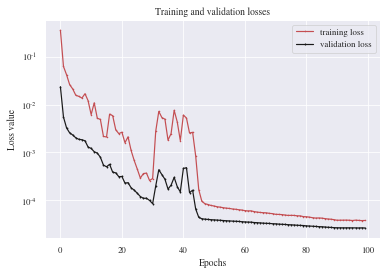

[I 2024-04-27 22:47:54,963] Trial 27 finished with value: 2.491996846559378e-05 and parameters: {'n_layers': 5, 'hidden_nodes': 199}. Best is trial 13 with value: 2.1065163592541287e-05.


train :  (789, 8)
val :  (98, 8)
test :  (98, 8)
Current test with :


    n_layers: 6
    hidden_nodes: 200



The average loss in epoch 2 is  0.3520700785641869
The average loss in epoch 3 is  0.06300060745949547
The average loss in epoch 4 is  0.045915903989225626
The average loss in epoch 5 is  0.03036335234840711
The average loss in epoch 6 is  0.02329800572867195
The average loss in epoch 7 is  0.018578824315530557
The average loss in epoch 8 is  0.015820630088758964
The average loss in epoch 9 is  0.009225072048138827
The average loss in epoch 10 is  0.024267515322814386
The average loss in epoch 11 is  0.015688753764455516
The average loss in epoch 12 is  0.009505032581121972
The average loss in epoch 13 is  0.009047033711491773
The average loss in epoch 14 is  0.0048793163829638315
The average loss in epoch 15 is  0.008389754531284174
The average loss in epoch 16 is  0.00838067780326431
The average loss in epoch 17 is  0.008976270609612888
The average loss in epoch 18 is  0.00

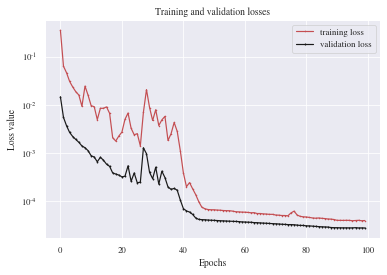

[I 2024-04-27 23:15:47,659] Trial 28 finished with value: 2.752960608745989e-05 and parameters: {'n_layers': 6, 'hidden_nodes': 200}. Best is trial 13 with value: 2.1065163592541287e-05.


train :  (789, 8)
val :  (98, 8)
test :  (98, 8)
Current test with :


    n_layers: 7
    hidden_nodes: 136



The average loss in epoch 2 is  0.49003008008003235
The average loss in epoch 3 is  0.07195507688447833
The average loss in epoch 4 is  0.05069027468562126
The average loss in epoch 5 is  0.03376848646439612
The average loss in epoch 6 is  0.02182028683212896
The average loss in epoch 7 is  0.016382231454675395
The average loss in epoch 8 is  0.014050692552700639
The average loss in epoch 9 is  0.012683956049537906
The average loss in epoch 10 is  0.014504755032248795
The average loss in epoch 11 is  0.010194269261167696
The average loss in epoch 12 is  0.0075587482618478434
The average loss in epoch 13 is  0.0054113566972470535
The average loss in epoch 14 is  0.004737474208620067
The average loss in epoch 15 is  0.005395569499038781
The average loss in epoch 16 is  0.005385646101785824
The average loss in epoch 17 is  0.006018792453687638
The average loss in epoch 18 is  0.

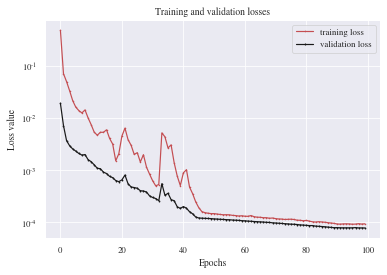

[I 2024-04-27 23:31:37,319] Trial 29 finished with value: 5.9543734970912766e-05 and parameters: {'n_layers': 7, 'hidden_nodes': 136}. Best is trial 13 with value: 2.1065163592541287e-05.


train :  (789, 8)
val :  (98, 8)
test :  (98, 8)
Current test with :


    n_layers: 5
    hidden_nodes: 106



The average loss in epoch 2 is  0.5779990612839659
The average loss in epoch 3 is  0.07261162111535668
The average loss in epoch 4 is  0.052799291908741
The average loss in epoch 5 is  0.038054242730140686
The average loss in epoch 6 is  0.02413620116810004
The average loss in epoch 7 is  0.016826122106673818
The average loss in epoch 8 is  0.01563473352386306
The average loss in epoch 9 is  0.012162635238685956
The average loss in epoch 10 is  0.013875510194338858
The average loss in epoch 11 is  0.020552624443856377
The average loss in epoch 12 is  0.012404938538869223
The average loss in epoch 13 is  0.010818929954742392
The average loss in epoch 14 is  0.00840408580067257
The average loss in epoch 15 is  0.006341137884495159
The average loss in epoch 16 is  0.007826720209171375
The average loss in epoch 17 is  0.008224754206215342
The average loss in epoch 18 is  0.006186

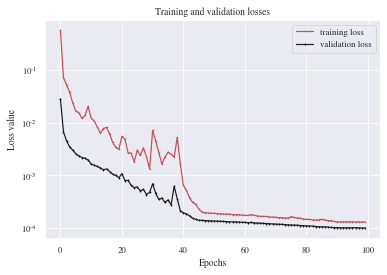

[I 2024-04-27 23:41:33,111] Trial 30 finished with value: 8.210349806009219e-05 and parameters: {'n_layers': 5, 'hidden_nodes': 106}. Best is trial 13 with value: 2.1065163592541287e-05.


train :  (789, 8)
val :  (98, 8)
test :  (98, 8)
Current test with :


    n_layers: 4
    hidden_nodes: 186



The average loss in epoch 2 is  0.3923991210758686
The average loss in epoch 3 is  0.06632004911080003
The average loss in epoch 4 is  0.047888757971425853
The average loss in epoch 5 is  0.03217101446352899
The average loss in epoch 6 is  0.019996363980074722
The average loss in epoch 7 is  0.015125386727352938
The average loss in epoch 8 is  0.013400277239270508
The average loss in epoch 9 is  0.01297174747257183
The average loss in epoch 10 is  0.00907791433079789
The average loss in epoch 11 is  0.01493813970591873
The average loss in epoch 12 is  0.006392490807532643
The average loss in epoch 13 is  0.006059748692981278
The average loss in epoch 14 is  0.004777934014176329
The average loss in epoch 15 is  0.00417816337721888
The average loss in epoch 16 is  0.0022672264991949
The average loss in epoch 17 is  0.0020851822628173977
The average loss in epoch 18 is  0.006709

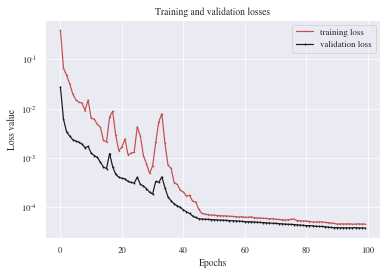

[I 2024-04-27 23:56:27,215] Trial 31 finished with value: 3.229091835058883e-05 and parameters: {'n_layers': 4, 'hidden_nodes': 186}. Best is trial 13 with value: 2.1065163592541287e-05.


train :  (789, 8)
val :  (98, 8)
test :  (98, 8)
Current test with :


    n_layers: 5
    hidden_nodes: 164



The average loss in epoch 2 is  0.4210873528694113
The average loss in epoch 3 is  0.06450234477718671
The average loss in epoch 4 is  0.04444685989680389
The average loss in epoch 5 is  0.028869465730773907
The average loss in epoch 6 is  0.01775796719205876
The average loss in epoch 7 is  0.014041122728182623
The average loss in epoch 8 is  0.010212468856479973
The average loss in epoch 9 is  0.009942167108723273
The average loss in epoch 10 is  0.013272680846663812
The average loss in epoch 11 is  0.00816839718997168
The average loss in epoch 12 is  0.0058280911956292885
The average loss in epoch 13 is  0.009402795869391412
The average loss in epoch 14 is  0.005353203625418246
The average loss in epoch 15 is  0.005768590276905646
The average loss in epoch 16 is  0.008023202205852916
The average loss in epoch 17 is  0.005744738601303349
The average loss in epoch 18 is  0.00

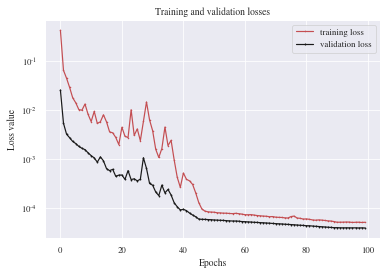

[I 2024-04-28 00:11:56,365] Trial 32 finished with value: 4.030913222177415e-05 and parameters: {'n_layers': 5, 'hidden_nodes': 164}. Best is trial 13 with value: 2.1065163592541287e-05.


train :  (789, 8)
val :  (98, 8)
test :  (98, 8)
Current test with :


    n_layers: 4
    hidden_nodes: 186



The average loss in epoch 2 is  0.3923991210758686
The average loss in epoch 3 is  0.06632004911080003
The average loss in epoch 4 is  0.047888757971425853
The average loss in epoch 5 is  0.03217101446352899
The average loss in epoch 6 is  0.019996363980074722
The average loss in epoch 7 is  0.015125386727352938
The average loss in epoch 8 is  0.013400277239270508
The average loss in epoch 9 is  0.01297174747257183
The average loss in epoch 10 is  0.00907791433079789
The average loss in epoch 11 is  0.01493813970591873
The average loss in epoch 12 is  0.006392490807532643
The average loss in epoch 13 is  0.006059748692981278
The average loss in epoch 14 is  0.004777934014176329
The average loss in epoch 15 is  0.00417816337721888
The average loss in epoch 16 is  0.0022672264991949
The average loss in epoch 17 is  0.0020851822628173977
The average loss in epoch 18 is  0.006709

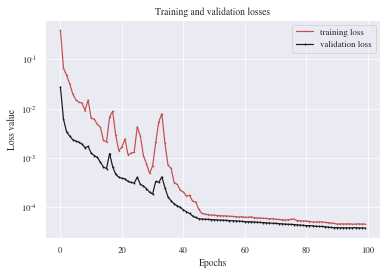

[I 2024-04-28 00:26:57,434] Trial 33 finished with value: 3.229091835058883e-05 and parameters: {'n_layers': 4, 'hidden_nodes': 186}. Best is trial 13 with value: 2.1065163592541287e-05.


train :  (789, 8)
val :  (98, 8)
test :  (98, 8)
Current test with :


    n_layers: 8
    hidden_nodes: 189



The average loss in epoch 2 is  0.3839970159654816
The average loss in epoch 3 is  0.0633063418790698
The average loss in epoch 4 is  0.04309580591507256
The average loss in epoch 5 is  0.027191874648754794
The average loss in epoch 6 is  0.028269804160421092
The average loss in epoch 7 is  0.02104405251642068
The average loss in epoch 8 is  0.017210358947825927
The average loss in epoch 9 is  0.012872058354939023
The average loss in epoch 10 is  0.013287822056251267
The average loss in epoch 11 is  0.01489329687319696
The average loss in epoch 12 is  0.005864048172952607
The average loss in epoch 13 is  0.0066310960877065854
The average loss in epoch 14 is  0.005672476322312529
The average loss in epoch 15 is  0.005448410549433902
The average loss in epoch 16 is  0.0033415588889814294
The average loss in epoch 17 is  0.006304949298889066
The average loss in epoch 18 is  0.00

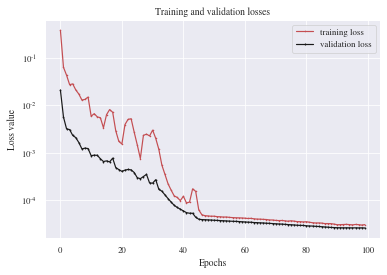

[I 2024-04-28 00:44:26,806] Trial 34 finished with value: 1.8884153291939706e-05 and parameters: {'n_layers': 8, 'hidden_nodes': 189}. Best is trial 34 with value: 1.8884153291939706e-05.


train :  (789, 8)
val :  (98, 8)
test :  (98, 8)
Current test with :


    n_layers: 7
    hidden_nodes: 157



The average loss in epoch 2 is  0.37476658448576927
The average loss in epoch 3 is  0.06829101173207164
The average loss in epoch 4 is  0.04633281069497267
The average loss in epoch 5 is  0.028228716847176354
The average loss in epoch 6 is  0.025719542056322098
The average loss in epoch 7 is  0.02034668787382543
The average loss in epoch 8 is  0.015159768944916626
The average loss in epoch 9 is  0.013603920272241036
The average loss in epoch 10 is  0.013548447750508785
The average loss in epoch 11 is  0.011987692443653941
The average loss in epoch 12 is  0.008026913138261685
The average loss in epoch 13 is  0.007301374047528952
The average loss in epoch 14 is  0.00431381436646916
The average loss in epoch 15 is  0.0041566830380664515
The average loss in epoch 16 is  0.00857377341405178
The average loss in epoch 17 is  0.008171597262844443
The average loss in epoch 18 is  0.00

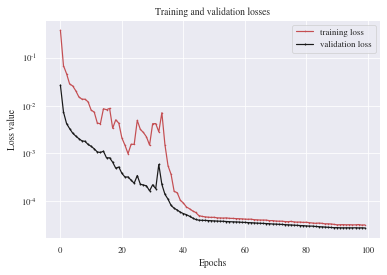

[I 2024-04-28 00:56:37,373] Trial 35 finished with value: 2.117246877698897e-05 and parameters: {'n_layers': 7, 'hidden_nodes': 157}. Best is trial 34 with value: 1.8884153291939706e-05.


train :  (789, 8)
val :  (98, 8)
test :  (98, 8)
Current test with :


    n_layers: 8
    hidden_nodes: 140



The average loss in epoch 2 is  0.46410755906254053
The average loss in epoch 3 is  0.06980935934310158
The average loss in epoch 4 is  0.04988406396781405
The average loss in epoch 5 is  0.0366764630501469
The average loss in epoch 6 is  0.02532835250409941
The average loss in epoch 7 is  0.017215055879205465
The average loss in epoch 8 is  0.01410976673165957
The average loss in epoch 9 is  0.013451557063187162
The average loss in epoch 10 is  0.015809915067317586
The average loss in epoch 11 is  0.009425643792686364
The average loss in epoch 12 is  0.0062290509037363035
The average loss in epoch 13 is  0.006719242121713857
The average loss in epoch 14 is  0.0038011209787024804
The average loss in epoch 15 is  0.0028511785155084604
The average loss in epoch 16 is  0.0033773464674595743
The average loss in epoch 17 is  0.0035688816860783845
The average loss in epoch 18 is  0

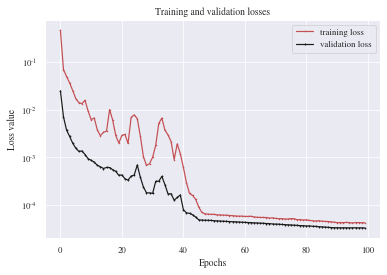

[I 2024-04-28 01:08:29,594] Trial 36 finished with value: 2.652255714256933e-05 and parameters: {'n_layers': 8, 'hidden_nodes': 140}. Best is trial 34 with value: 1.8884153291939706e-05.


train :  (789, 8)
val :  (98, 8)
test :  (98, 8)
Current test with :


    n_layers: 8
    hidden_nodes: 120



The average loss in epoch 2 is  0.4559849559639891
The average loss in epoch 3 is  0.07254527012507121
The average loss in epoch 4 is  0.05287689669057727
The average loss in epoch 5 is  0.03782484998616079
The average loss in epoch 6 is  0.025502142341186602
The average loss in epoch 7 is  0.018413215565184753
The average loss in epoch 8 is  0.015293928251291314
The average loss in epoch 9 is  0.013700793652484814
The average loss in epoch 10 is  0.01120372578346481
The average loss in epoch 11 is  0.007483686611521989
The average loss in epoch 12 is  0.008444176113698632
The average loss in epoch 13 is  0.006328653515083715
The average loss in epoch 14 is  0.004545902484096587
The average loss in epoch 15 is  0.0054187244483424974
The average loss in epoch 16 is  0.008235745946876705
The average loss in epoch 17 is  0.009668411628808826
The average loss in epoch 18 is  0.00

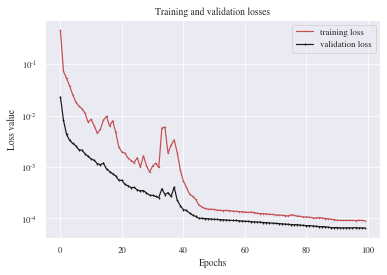

[I 2024-04-28 01:18:44,488] Trial 37 finished with value: 6.875210317911884e-05 and parameters: {'n_layers': 8, 'hidden_nodes': 120}. Best is trial 34 with value: 1.8884153291939706e-05.


train :  (789, 8)
val :  (98, 8)
test :  (98, 8)
Current test with :


    n_layers: 7
    hidden_nodes: 156



The average loss in epoch 2 is  0.43894432454059523
The average loss in epoch 3 is  0.06892484333366156
The average loss in epoch 4 is  0.04965589397276441
The average loss in epoch 5 is  0.03383966077429553
The average loss in epoch 6 is  0.024528854216138523
The average loss in epoch 7 is  0.02022594993468374
The average loss in epoch 8 is  0.013522587367333472
The average loss in epoch 9 is  0.00980792766980206
The average loss in epoch 10 is  0.01203597717297574
The average loss in epoch 11 is  0.01135806778135399
The average loss in epoch 12 is  0.00846148132889842
The average loss in epoch 13 is  0.0053295431134756655
The average loss in epoch 14 is  0.005266456049866974
The average loss in epoch 15 is  0.004635218899541845
The average loss in epoch 16 is  0.006567915785126388
The average loss in epoch 17 is  0.005545445271612455
The average loss in epoch 18 is  0.00247

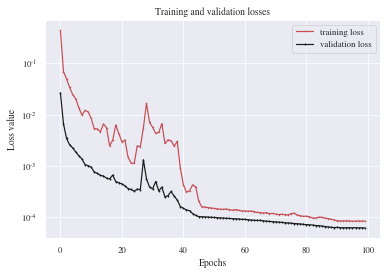

[I 2024-04-28 01:30:45,466] Trial 38 finished with value: 6.887854994949663e-05 and parameters: {'n_layers': 7, 'hidden_nodes': 156}. Best is trial 34 with value: 1.8884153291939706e-05.


train :  (789, 8)
val :  (98, 8)
test :  (98, 8)
Current test with :


    n_layers: 8
    hidden_nodes: 119



The average loss in epoch 2 is  0.44646615783373517
The average loss in epoch 3 is  0.07091479329392314
The average loss in epoch 4 is  0.052638982267429434
The average loss in epoch 5 is  0.03841482459877928
The average loss in epoch 6 is  0.02599828507906447
The average loss in epoch 7 is  0.01689612112628917
The average loss in epoch 8 is  0.016028518594490986
The average loss in epoch 9 is  0.014477823860943317
The average loss in epoch 10 is  0.01146432194703569
The average loss in epoch 11 is  0.01406612346181646
The average loss in epoch 12 is  0.007766433215389649
The average loss in epoch 13 is  0.0054627910333996015
The average loss in epoch 14 is  0.004126282923001175
The average loss in epoch 15 is  0.004813508334336802
The average loss in epoch 16 is  0.004119496695542087
The average loss in epoch 17 is  0.005609632537622626
The average loss in epoch 18 is  0.005

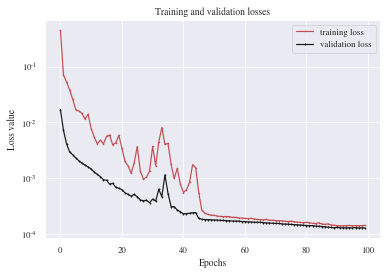

[I 2024-04-28 01:41:31,134] Trial 39 finished with value: 9.178425811156119e-05 and parameters: {'n_layers': 8, 'hidden_nodes': 119}. Best is trial 34 with value: 1.8884153291939706e-05.


train :  (789, 8)
val :  (98, 8)
test :  (98, 8)
Current test with :


    n_layers: 7
    hidden_nodes: 89



The average loss in epoch 2 is  0.5615476875876387
The average loss in epoch 3 is  0.07764769919837515
The average loss in epoch 4 is  0.055761438173552356
The average loss in epoch 5 is  0.038398841551194586
The average loss in epoch 6 is  0.023143267026171088
The average loss in epoch 7 is  0.018305717889840405
The average loss in epoch 8 is  0.013140671770088375
The average loss in epoch 9 is  0.011893033476856848
The average loss in epoch 10 is  0.010467665366983661
The average loss in epoch 11 is  0.013583302963525057
The average loss in epoch 12 is  0.0072159857566778856
The average loss in epoch 13 is  0.004306803767879804
The average loss in epoch 14 is  0.003791670373175293
The average loss in epoch 15 is  0.0057324282922005905
The average loss in epoch 16 is  0.005807415165084724
The average loss in epoch 17 is  0.005855013558175415
The average loss in epoch 18 is  0

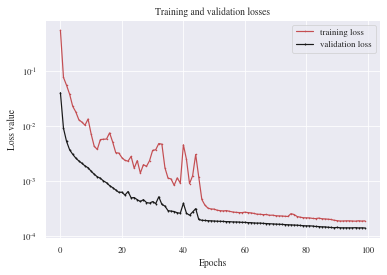

[I 2024-04-28 01:49:06,734] Trial 40 finished with value: 0.0001228412202585856 and parameters: {'n_layers': 7, 'hidden_nodes': 89}. Best is trial 34 with value: 1.8884153291939706e-05.


train :  (789, 8)
val :  (98, 8)
test :  (98, 8)
Current test with :


    n_layers: 8
    hidden_nodes: 177



The average loss in epoch 2 is  0.3795579370732109
The average loss in epoch 3 is  0.06469250392789642
The average loss in epoch 4 is  0.04598977556452155
The average loss in epoch 5 is  0.030190493445843458
The average loss in epoch 6 is  0.021652875778575737
The average loss in epoch 7 is  0.021086253963100415
The average loss in epoch 8 is  0.017463269488265116
The average loss in epoch 9 is  0.012022234771090249
The average loss in epoch 10 is  0.01025095380221804
The average loss in epoch 11 is  0.013559774709089348
The average loss in epoch 12 is  0.005929692531935871
The average loss in epoch 13 is  0.004499519418459386
The average loss in epoch 14 is  0.007473395419462274
The average loss in epoch 15 is  0.007365307305008173
The average loss in epoch 16 is  0.004457690141862258
The average loss in epoch 17 is  0.00516407565252545
The average loss in epoch 18 is  0.004

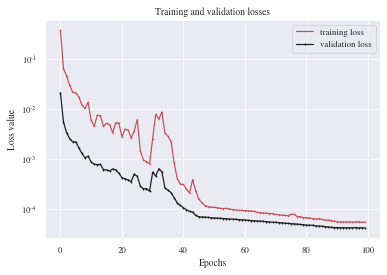

[I 2024-04-28 02:03:51,722] Trial 41 finished with value: 4.328620471656542e-05 and parameters: {'n_layers': 8, 'hidden_nodes': 177}. Best is trial 34 with value: 1.8884153291939706e-05.


train :  (789, 8)
val :  (98, 8)
test :  (98, 8)
Current test with :


    n_layers: 6
    hidden_nodes: 156



The average loss in epoch 2 is  0.44551233761012554
The average loss in epoch 3 is  0.06849109924708803
The average loss in epoch 4 is  0.046674994907031454
The average loss in epoch 5 is  0.02689286961685866
The average loss in epoch 6 is  0.02121140439218531
The average loss in epoch 7 is  0.01334723694405208
The average loss in epoch 8 is  0.01206923338274161
The average loss in epoch 9 is  0.014836157322861254
The average loss in epoch 10 is  0.01592896576039493
The average loss in epoch 11 is  0.013204956252593547
The average loss in epoch 12 is  0.007603534691346188
The average loss in epoch 13 is  0.006190425153666486
The average loss in epoch 14 is  0.004978411947377026
The average loss in epoch 15 is  0.006203484964013721
The average loss in epoch 16 is  0.0037082029642382017
The average loss in epoch 17 is  0.004486654167218755
The average loss in epoch 18 is  0.005

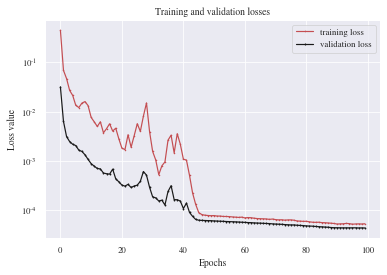

[I 2024-04-28 02:14:44,657] Trial 42 finished with value: 2.769843376014738e-05 and parameters: {'n_layers': 6, 'hidden_nodes': 156}. Best is trial 34 with value: 1.8884153291939706e-05.


train :  (789, 8)
val :  (98, 8)
test :  (98, 8)
Current test with :


    n_layers: 7
    hidden_nodes: 169



The average loss in epoch 2 is  0.4268520663802822
The average loss in epoch 3 is  0.06561864446848631
The average loss in epoch 4 is  0.04604948746661345
The average loss in epoch 5 is  0.029076282711078722
The average loss in epoch 6 is  0.019667652474405866
The average loss in epoch 7 is  0.015356223564594984
The average loss in epoch 8 is  0.010341102354383716
The average loss in epoch 9 is  0.010936801205389202
The average loss in epoch 10 is  0.010930667844756195
The average loss in epoch 11 is  0.018286275444552302
The average loss in epoch 12 is  0.006430058914702386
The average loss in epoch 13 is  0.0072405106232812004
The average loss in epoch 14 is  0.00597404744864131
The average loss in epoch 15 is  0.008541404114415249
The average loss in epoch 16 is  0.0076761893966856105
The average loss in epoch 17 is  0.006723409460391849
The average loss in epoch 18 is  0.

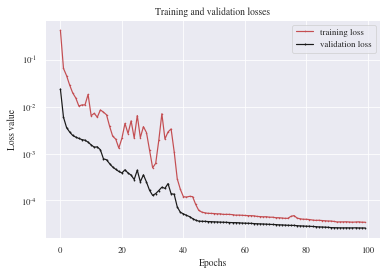

[I 2024-04-28 02:27:48,783] Trial 43 finished with value: 2.2212041081589238e-05 and parameters: {'n_layers': 7, 'hidden_nodes': 169}. Best is trial 34 with value: 1.8884153291939706e-05.


train :  (789, 8)
val :  (98, 8)
test :  (98, 8)
Current test with :


    n_layers: 7
    hidden_nodes: 146



The average loss in epoch 2 is  0.4260517641281088
The average loss in epoch 3 is  0.07171408971771598
The average loss in epoch 4 is  0.05258390152206024
The average loss in epoch 5 is  0.034511431896438204
The average loss in epoch 6 is  0.02410932374186814
The average loss in epoch 7 is  0.024146510132898886
The average loss in epoch 8 is  0.013963471089179317
The average loss in epoch 9 is  0.016948126334076125
The average loss in epoch 10 is  0.014237011433579028
The average loss in epoch 11 is  0.011659923960299542
The average loss in epoch 12 is  0.0065849810489453375
The average loss in epoch 13 is  0.0057641767198219895
The average loss in epoch 14 is  0.006477362437484165
The average loss in epoch 15 is  0.0037035665785272918
The average loss in epoch 16 is  0.0033206111402250826
The average loss in epoch 17 is  0.003240692890055167
The average loss in epoch 18 is  

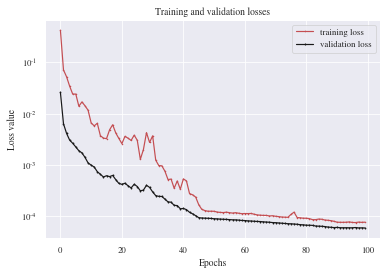

[I 2024-04-28 02:39:06,732] Trial 44 finished with value: 6.164510223067733e-05 and parameters: {'n_layers': 7, 'hidden_nodes': 146}. Best is trial 34 with value: 1.8884153291939706e-05.


train :  (789, 8)
val :  (98, 8)
test :  (98, 8)
Current test with :


    n_layers: 7
    hidden_nodes: 168



The average loss in epoch 2 is  0.3930185853193204
The average loss in epoch 3 is  0.06507571755597989
The average loss in epoch 4 is  0.044054902313898005
The average loss in epoch 5 is  0.027526455310483772
The average loss in epoch 6 is  0.021069413283839822
The average loss in epoch 7 is  0.021900190544935565
The average loss in epoch 8 is  0.017111551016569138
The average loss in epoch 9 is  0.014520085688369969
The average loss in epoch 10 is  0.017641832237131894
The average loss in epoch 11 is  0.01412764893999944
The average loss in epoch 12 is  0.007850985469607016
The average loss in epoch 13 is  0.007655185259257753
The average loss in epoch 14 is  0.00593415023953033
The average loss in epoch 15 is  0.006301574835864206
The average loss in epoch 16 is  0.005406486782400559
The average loss in epoch 17 is  0.006037267031691347
The average loss in epoch 18 is  0.00

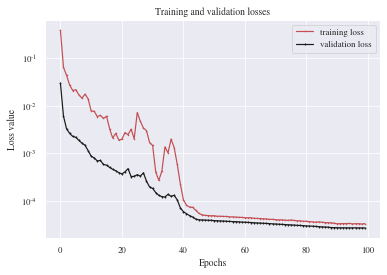

[I 2024-04-28 02:51:48,927] Trial 45 finished with value: 1.7345961365769816e-05 and parameters: {'n_layers': 7, 'hidden_nodes': 168}. Best is trial 45 with value: 1.7345961365769816e-05.


train :  (789, 8)
val :  (98, 8)
test :  (98, 8)
Current test with :


    n_layers: 7
    hidden_nodes: 169



The average loss in epoch 2 is  0.4268520663802822
The average loss in epoch 3 is  0.06561864446848631
The average loss in epoch 4 is  0.04604948746661345
The average loss in epoch 5 is  0.029076282711078722
The average loss in epoch 6 is  0.019667652474405866
The average loss in epoch 7 is  0.015356223564594984
The average loss in epoch 8 is  0.010341102354383716
The average loss in epoch 9 is  0.010936801205389202
The average loss in epoch 10 is  0.010930667844756195
The average loss in epoch 11 is  0.018286275444552302
The average loss in epoch 12 is  0.006430058914702386
The average loss in epoch 13 is  0.0072405106232812004
The average loss in epoch 14 is  0.00597404744864131
The average loss in epoch 15 is  0.008541404114415249
The average loss in epoch 16 is  0.0076761893966856105
The average loss in epoch 17 is  0.006723409460391849
The average loss in epoch 18 is  0.

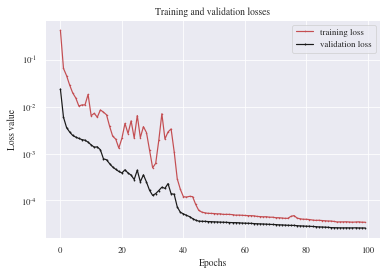

[I 2024-04-28 03:04:46,603] Trial 46 finished with value: 2.2212041081589238e-05 and parameters: {'n_layers': 7, 'hidden_nodes': 169}. Best is trial 45 with value: 1.7345961365769816e-05.


train :  (789, 8)
val :  (98, 8)
test :  (98, 8)
Current test with :


    n_layers: 7
    hidden_nodes: 160



The average loss in epoch 2 is  0.4421967600161831
The average loss in epoch 3 is  0.06748407970493038
The average loss in epoch 4 is  0.043928869999945164
The average loss in epoch 5 is  0.027081009776641924
The average loss in epoch 6 is  0.020216981298290193
The average loss in epoch 7 is  0.017667182410756748
The average loss in epoch 8 is  0.01262405898887664
The average loss in epoch 9 is  0.012420182038719455
The average loss in epoch 10 is  0.011855298866673062
The average loss in epoch 11 is  0.011600379250012338
The average loss in epoch 12 is  0.0061075447786909836
The average loss in epoch 13 is  0.005956148495897651
The average loss in epoch 14 is  0.004216288167905684
The average loss in epoch 15 is  0.0036665974960972867
The average loss in epoch 16 is  0.0030556627025362104
The average loss in epoch 17 is  0.003371406356260801
The average loss in epoch 18 is  

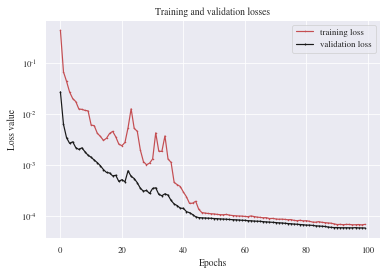

[I 2024-04-28 03:16:39,756] Trial 47 finished with value: 4.814279603019001e-05 and parameters: {'n_layers': 7, 'hidden_nodes': 160}. Best is trial 45 with value: 1.7345961365769816e-05.


train :  (789, 8)
val :  (98, 8)
test :  (98, 8)
Current test with :


    n_layers: 6
    hidden_nodes: 145



The average loss in epoch 2 is  0.4599474994465709
The average loss in epoch 3 is  0.07003239433591564
The average loss in epoch 4 is  0.04806650569662452
The average loss in epoch 5 is  0.031292292987927794
The average loss in epoch 6 is  0.018139544175937772
The average loss in epoch 7 is  0.014809326734393835
The average loss in epoch 8 is  0.011868958400251964
The average loss in epoch 9 is  0.00847511125418047
The average loss in epoch 10 is  0.015519524264770249
The average loss in epoch 11 is  0.008753166941460222
The average loss in epoch 12 is  0.006148082223565628
The average loss in epoch 13 is  0.006517332706910868
The average loss in epoch 14 is  0.004012846213299781
The average loss in epoch 15 is  0.003982008289312944
The average loss in epoch 16 is  0.0026678633488093815
The average loss in epoch 17 is  0.002699116235210871
The average loss in epoch 18 is  0.0

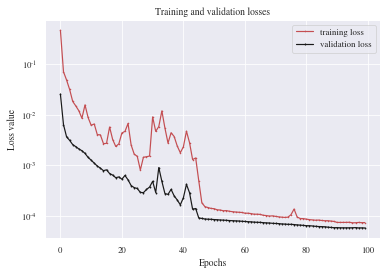

[I 2024-04-28 03:27:00,400] Trial 48 finished with value: 4.944730687613737e-05 and parameters: {'n_layers': 6, 'hidden_nodes': 145}. Best is trial 45 with value: 1.7345961365769816e-05.


train :  (789, 8)
val :  (98, 8)
test :  (98, 8)
Current test with :


    n_layers: 8
    hidden_nodes: 179



The average loss in epoch 2 is  0.36178264766931534
The average loss in epoch 3 is  0.06283250559742252
The average loss in epoch 4 is  0.04296412148202459
The average loss in epoch 5 is  0.02889158413745463
The average loss in epoch 6 is  0.023524980604027707
The average loss in epoch 7 is  0.02370698513307919
The average loss in epoch 8 is  0.021597093359256785
The average loss in epoch 9 is  0.019613619699763756
The average loss in epoch 10 is  0.01899263239465654
The average loss in epoch 11 is  0.014069515746086836
The average loss in epoch 12 is  0.01175117694462339
The average loss in epoch 13 is  0.008777880051638931
The average loss in epoch 14 is  0.008672007029720893
The average loss in epoch 15 is  0.004340867919381708
The average loss in epoch 16 is  0.004588758543832228
The average loss in epoch 17 is  0.006224869915361826
The average loss in epoch 18 is  0.0065

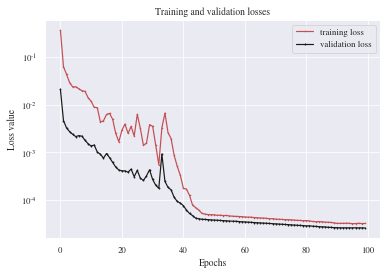

[I 2024-04-28 03:42:05,296] Trial 49 finished with value: 2.1302210851569874e-05 and parameters: {'n_layers': 8, 'hidden_nodes': 179}. Best is trial 45 with value: 1.7345961365769816e-05.


train :  (789, 8)
val :  (98, 8)
test :  (98, 8)
Current test with :


    n_layers: 8
    hidden_nodes: 179



The average loss in epoch 2 is  0.36178264766931534
The average loss in epoch 3 is  0.06283250559742252
The average loss in epoch 4 is  0.04296412148202459
The average loss in epoch 5 is  0.02889158413745463
The average loss in epoch 6 is  0.023524980604027707
The average loss in epoch 7 is  0.02370698513307919
The average loss in epoch 8 is  0.021597093359256785
The average loss in epoch 9 is  0.019613619699763756
The average loss in epoch 10 is  0.01899263239465654
The average loss in epoch 11 is  0.014069515746086836
The average loss in epoch 12 is  0.01175117694462339
The average loss in epoch 13 is  0.008777880051638931
The average loss in epoch 14 is  0.008672007029720893
The average loss in epoch 15 is  0.004340867919381708
The average loss in epoch 16 is  0.004588758543832228
The average loss in epoch 17 is  0.006224869915361826
The average loss in epoch 18 is  0.0065

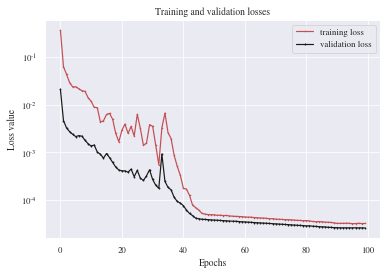

[I 2024-04-28 03:57:17,263] Trial 50 finished with value: 2.1302210851569874e-05 and parameters: {'n_layers': 8, 'hidden_nodes': 179}. Best is trial 45 with value: 1.7345961365769816e-05.


train :  (789, 8)
val :  (98, 8)
test :  (98, 8)
Current test with :


    n_layers: 8
    hidden_nodes: 181



The average loss in epoch 2 is  0.37278712044159573
The average loss in epoch 3 is  0.06557234516367316
The average loss in epoch 4 is  0.04475752481569847
The average loss in epoch 5 is  0.030173871743803222
The average loss in epoch 6 is  0.019618765256988507
The average loss in epoch 7 is  0.017506171328326065
The average loss in epoch 8 is  0.011750286542034397
The average loss in epoch 9 is  0.010858236462809145
The average loss in epoch 10 is  0.018446442011433344
The average loss in epoch 11 is  0.011837228123719493
The average loss in epoch 12 is  0.006624150555580854
The average loss in epoch 13 is  0.008050790386429677
The average loss in epoch 14 is  0.005876202213888367
The average loss in epoch 15 is  0.005777522543212399
The average loss in epoch 16 is  0.003101279338200887
The average loss in epoch 17 is  0.006871299953976025
The average loss in epoch 18 is  0.

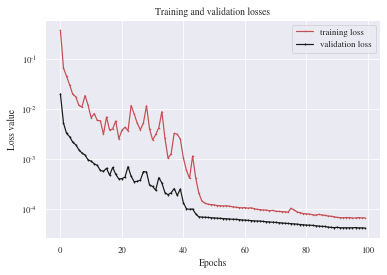

[I 2024-04-28 04:12:29,313] Trial 51 finished with value: 5.676606674545326e-05 and parameters: {'n_layers': 8, 'hidden_nodes': 181}. Best is trial 45 with value: 1.7345961365769816e-05.


train :  (789, 8)
val :  (98, 8)
test :  (98, 8)
Current test with :


    n_layers: 8
    hidden_nodes: 174



The average loss in epoch 2 is  0.37818045013894636
The average loss in epoch 3 is  0.06516832082221906
The average loss in epoch 4 is  0.041362396984671555
The average loss in epoch 5 is  0.02325416690049072
The average loss in epoch 6 is  0.015555593379152318
The average loss in epoch 7 is  0.016543137666303664
The average loss in epoch 8 is  0.013341912999749184
The average loss in epoch 9 is  0.01596788545915236
The average loss in epoch 10 is  0.01146013462372745
The average loss in epoch 11 is  0.011671672808006406
The average loss in epoch 12 is  0.007364819583017379
The average loss in epoch 13 is  0.005005074141081423
The average loss in epoch 14 is  0.006708493106998503
The average loss in epoch 15 is  0.0048051307870385545
The average loss in epoch 16 is  0.0023175952422510213
The average loss in epoch 17 is  0.005246342746734929
The average loss in epoch 18 is  0.

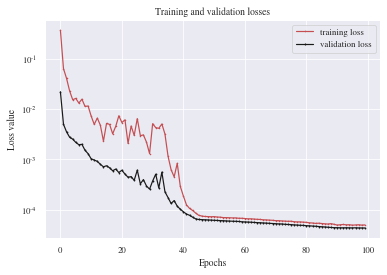

[I 2024-04-28 04:27:19,350] Trial 52 finished with value: 2.5483362768840724e-05 and parameters: {'n_layers': 8, 'hidden_nodes': 174}. Best is trial 45 with value: 1.7345961365769816e-05.


train :  (789, 8)
val :  (98, 8)
test :  (98, 8)
Current test with :


    n_layers: 8
    hidden_nodes: 153



The average loss in epoch 2 is  0.4236540695031484
The average loss in epoch 3 is  0.06862356808657448
The average loss in epoch 4 is  0.04552777390927076
The average loss in epoch 5 is  0.026272169430740178
The average loss in epoch 6 is  0.017417234795478482
The average loss in epoch 7 is  0.014553855619548509
The average loss in epoch 8 is  0.009723583430362245
The average loss in epoch 9 is  0.006850342382676899
The average loss in epoch 10 is  0.012045390457691004
The average loss in epoch 11 is  0.018981723308873672
The average loss in epoch 12 is  0.009284451138228178
The average loss in epoch 13 is  0.009066328037685404
The average loss in epoch 14 is  0.00736448463673393
The average loss in epoch 15 is  0.007543652745274206
The average loss in epoch 16 is  0.00417917004475991
The average loss in epoch 17 is  0.0055704494200957315
The average loss in epoch 18 is  0.00

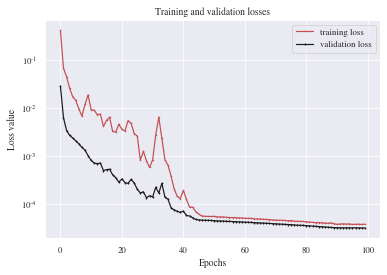

[I 2024-04-28 04:40:11,300] Trial 53 finished with value: 1.6595504614279347e-05 and parameters: {'n_layers': 8, 'hidden_nodes': 153}. Best is trial 53 with value: 1.6595504614279347e-05.


train :  (789, 8)
val :  (98, 8)
test :  (98, 8)
Current test with :


    n_layers: 8
    hidden_nodes: 152



The average loss in epoch 2 is  0.40031719642380875
The average loss in epoch 3 is  0.06800673917556803
The average loss in epoch 4 is  0.046466082179298006
The average loss in epoch 5 is  0.029464959089333814
The average loss in epoch 6 is  0.022180863850129146
The average loss in epoch 7 is  0.015509936260059476
The average loss in epoch 8 is  0.013913412500793735
The average loss in epoch 9 is  0.014428311687273284
The average loss in epoch 10 is  0.014683947626811763
The average loss in epoch 11 is  0.01131389212484161
The average loss in epoch 12 is  0.005726910370867699
The average loss in epoch 13 is  0.005397500945643212
The average loss in epoch 14 is  0.004245260769190888
The average loss in epoch 15 is  0.003798724685717995
The average loss in epoch 16 is  0.0043232939691127585
The average loss in epoch 17 is  0.003519176888706473
The average loss in epoch 18 is  0

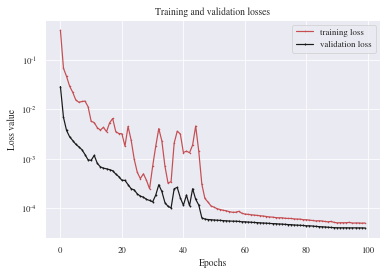

[I 2024-04-28 04:52:45,306] Trial 54 finished with value: 2.2496007716975174e-05 and parameters: {'n_layers': 8, 'hidden_nodes': 152}. Best is trial 53 with value: 1.6595504614279347e-05.


train :  (789, 8)
val :  (98, 8)
test :  (98, 8)
Current test with :


    n_layers: 8
    hidden_nodes: 192



The average loss in epoch 2 is  0.40113522950559855
The average loss in epoch 3 is  0.06286098699395855
The average loss in epoch 4 is  0.04291850607842207
The average loss in epoch 5 is  0.03136843342023591
The average loss in epoch 6 is  0.025080102340628702
The average loss in epoch 7 is  0.02299602368536095
The average loss in epoch 8 is  0.01513064563429604
The average loss in epoch 9 is  0.014738008612766862
The average loss in epoch 10 is  0.011254612977306047
The average loss in epoch 11 is  0.012698813884829482
The average loss in epoch 12 is  0.009273070221145948
The average loss in epoch 13 is  0.0059961916219132645
The average loss in epoch 14 is  0.0030886387588301054
The average loss in epoch 15 is  0.003596859402023256
The average loss in epoch 16 is  0.004605603540161003
The average loss in epoch 17 is  0.003758448646597875
The average loss in epoch 18 is  0.0

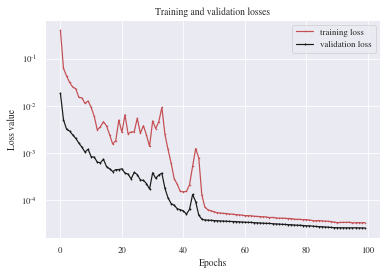

[I 2024-04-28 05:08:15,670] Trial 55 finished with value: 2.0352560237146606e-05 and parameters: {'n_layers': 8, 'hidden_nodes': 192}. Best is trial 53 with value: 1.6595504614279347e-05.


train :  (789, 8)
val :  (98, 8)
test :  (98, 8)
Current test with :


    n_layers: 7
    hidden_nodes: 192



The average loss in epoch 2 is  0.3441314799711108
The average loss in epoch 3 is  0.06132245296612382
The average loss in epoch 4 is  0.03928342228755355
The average loss in epoch 5 is  0.026833829159537952
The average loss in epoch 6 is  0.02737642397793631
The average loss in epoch 7 is  0.01856135270403077
The average loss in epoch 8 is  0.013280232630980512
The average loss in epoch 9 is  0.017018627802220482
The average loss in epoch 10 is  0.01415753624557207
The average loss in epoch 11 is  0.023076667139927547
The average loss in epoch 12 is  0.010655222150186697
The average loss in epoch 13 is  0.00747902668081224
The average loss in epoch 14 is  0.006492135192578037
The average loss in epoch 15 is  0.00666939565174592
The average loss in epoch 16 is  0.005956396673961232
The average loss in epoch 17 is  0.005773700162535533
The average loss in epoch 18 is  0.009061

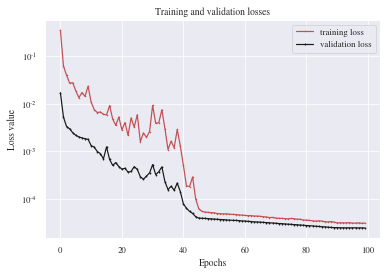

[I 2024-04-28 05:22:35,965] Trial 56 finished with value: 1.7954058445160567e-05 and parameters: {'n_layers': 7, 'hidden_nodes': 192}. Best is trial 53 with value: 1.6595504614279347e-05.


train :  (789, 8)
val :  (98, 8)
test :  (98, 8)
Current test with :


    n_layers: 8
    hidden_nodes: 191



The average loss in epoch 2 is  0.44239296795179445
The average loss in epoch 3 is  0.06586186137671272
The average loss in epoch 4 is  0.04477602313272655
The average loss in epoch 5 is  0.0281591279587398
The average loss in epoch 6 is  0.024442573310807347
The average loss in epoch 7 is  0.016067695765135188
The average loss in epoch 8 is  0.018044596421532333
The average loss in epoch 9 is  0.010173743920555959
The average loss in epoch 10 is  0.01276000887931635
The average loss in epoch 11 is  0.014243633854979029
The average loss in epoch 12 is  0.007553494981645296
The average loss in epoch 13 is  0.009880726788348207
The average loss in epoch 14 is  0.004967919803069283
The average loss in epoch 15 is  0.0032446807308588177
The average loss in epoch 16 is  0.00236110189386333
The average loss in epoch 17 is  0.004654743931799506
The average loss in epoch 18 is  0.005

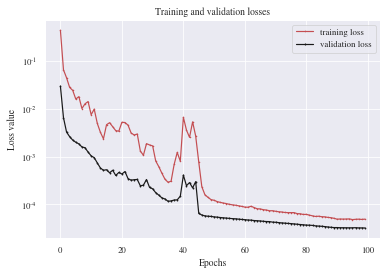

[I 2024-04-28 05:39:18,234] Trial 57 finished with value: 3.3339765733332564e-05 and parameters: {'n_layers': 8, 'hidden_nodes': 191}. Best is trial 53 with value: 1.6595504614279347e-05.


train :  (789, 8)
val :  (98, 8)
test :  (98, 8)
Current test with :


    n_layers: 6
    hidden_nodes: 191



The average loss in epoch 2 is  0.3272668377806743
The average loss in epoch 3 is  0.061203902742515005
The average loss in epoch 4 is  0.03847261401824653
The average loss in epoch 5 is  0.02222497737966478
The average loss in epoch 6 is  0.017304055897208553
The average loss in epoch 7 is  0.01925880085521688
The average loss in epoch 8 is  0.011857355556761226
The average loss in epoch 9 is  0.010076842561829835
The average loss in epoch 10 is  0.016015420454399038
The average loss in epoch 11 is  0.007666577138782789
The average loss in epoch 12 is  0.005342370335711166
The average loss in epoch 13 is  0.0065875206103858846
The average loss in epoch 14 is  0.004597247811034322
The average loss in epoch 15 is  0.008240205468609929
The average loss in epoch 16 is  0.005503032492318501
The average loss in epoch 17 is  0.005910395654306437
The average loss in epoch 18 is  0.0

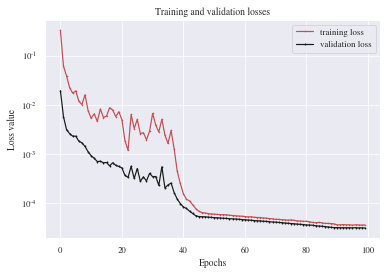

[I 2024-04-28 05:52:55,069] Trial 58 finished with value: 2.72778725634941e-05 and parameters: {'n_layers': 6, 'hidden_nodes': 191}. Best is trial 53 with value: 1.6595504614279347e-05.


train :  (789, 8)
val :  (98, 8)
test :  (98, 8)
Current test with :


    n_layers: 7
    hidden_nodes: 192



The average loss in epoch 2 is  0.3441314799711108
The average loss in epoch 3 is  0.06132245296612382
The average loss in epoch 4 is  0.03928342228755355
The average loss in epoch 5 is  0.026833829159537952
The average loss in epoch 6 is  0.02737642397793631
The average loss in epoch 7 is  0.01856135270403077
The average loss in epoch 8 is  0.013280232630980512
The average loss in epoch 9 is  0.017018627802220482
The average loss in epoch 10 is  0.01415753624557207
The average loss in epoch 11 is  0.023076667139927547
The average loss in epoch 12 is  0.010655222150186697
The average loss in epoch 13 is  0.00747902668081224
The average loss in epoch 14 is  0.006492135192578037
The average loss in epoch 15 is  0.00666939565174592
The average loss in epoch 16 is  0.005956396673961232
The average loss in epoch 17 is  0.005773700162535533
The average loss in epoch 18 is  0.009061

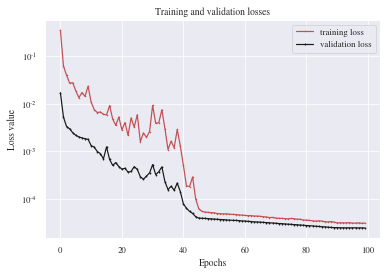

[I 2024-04-28 06:07:11,046] Trial 59 finished with value: 1.7954058445160567e-05 and parameters: {'n_layers': 7, 'hidden_nodes': 192}. Best is trial 53 with value: 1.6595504614279347e-05.


train :  (789, 8)
val :  (98, 8)
test :  (98, 8)
Current test with :


    n_layers: 7
    hidden_nodes: 37



The average loss in epoch 2 is  1.4203919333716233
The average loss in epoch 3 is  0.2046627507855495
The average loss in epoch 4 is  0.08177908820410569
The average loss in epoch 5 is  0.06544515940671165
The average loss in epoch 6 is  0.057964128286888204
The average loss in epoch 7 is  0.049719140554467835
The average loss in epoch 8 is  0.039063081766168274
The average loss in epoch 9 is  0.026232182203481596
The average loss in epoch 10 is  0.01873068461039414
The average loss in epoch 11 is  0.016143504103335243
The average loss in epoch 12 is  0.011315524306458732
The average loss in epoch 13 is  0.009597415182118615
The average loss in epoch 14 is  0.009630639125437787
The average loss in epoch 15 is  0.008872565949180474
The average loss in epoch 16 is  0.007462880729387204
The average loss in epoch 17 is  0.0070607233404492336
The average loss in epoch 18 is  0.0069

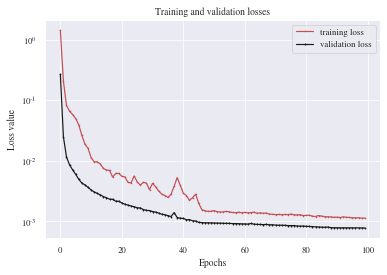

[I 2024-04-28 06:12:52,740] Trial 60 finished with value: 0.000605155314880558 and parameters: {'n_layers': 7, 'hidden_nodes': 37}. Best is trial 53 with value: 1.6595504614279347e-05.


train :  (789, 8)
val :  (98, 8)
test :  (98, 8)
Current test with :


    n_layers: 7
    hidden_nodes: 189



The average loss in epoch 2 is  0.4250968008612593
The average loss in epoch 3 is  0.06632349189991753
The average loss in epoch 4 is  0.04747058947881063
The average loss in epoch 5 is  0.031875929329544306
The average loss in epoch 6 is  0.021444350752669077
The average loss in epoch 7 is  0.016628386142353218
The average loss in epoch 8 is  0.014066203031688929
The average loss in epoch 9 is  0.012205702757152418
The average loss in epoch 10 is  0.010952687376023581
The average loss in epoch 11 is  0.016230136000861723
The average loss in epoch 12 is  0.007835876196622849
The average loss in epoch 13 is  0.005919425001290317
The average loss in epoch 14 is  0.006769308859171967
The average loss in epoch 15 is  0.009056413390984138
The average loss in epoch 16 is  0.005236091596695284
The average loss in epoch 17 is  0.00626373907046703
The average loss in epoch 18 is  0.00

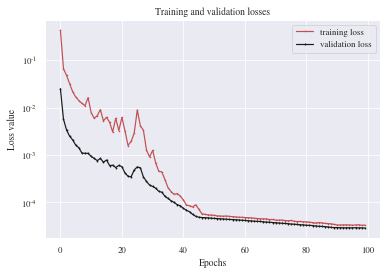

[I 2024-04-28 06:27:35,272] Trial 61 finished with value: 2.2583182019208242e-05 and parameters: {'n_layers': 7, 'hidden_nodes': 189}. Best is trial 53 with value: 1.6595504614279347e-05.


train :  (789, 8)
val :  (98, 8)
test :  (98, 8)
Current test with :


    n_layers: 8
    hidden_nodes: 171



The average loss in epoch 2 is  0.37071286390225094
The average loss in epoch 3 is  0.06379890907555819
The average loss in epoch 4 is  0.04324196558445692
The average loss in epoch 5 is  0.027151010154436033
The average loss in epoch 6 is  0.021421447473888595
The average loss in epoch 7 is  0.019061543939945597
The average loss in epoch 8 is  0.017157372863342363
The average loss in epoch 9 is  0.011993158996726075
The average loss in epoch 10 is  0.012170574724829445
The average loss in epoch 11 is  0.015219806033807496
The average loss in epoch 12 is  0.007216858861890311
The average loss in epoch 13 is  0.005759452159206073
The average loss in epoch 14 is  0.006453767341251175
The average loss in epoch 15 is  0.006713714828947559
The average loss in epoch 16 is  0.00713972223456949
The average loss in epoch 17 is  0.003892079354651893
The average loss in epoch 18 is  0.0

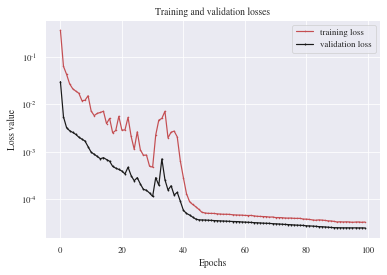

[I 2024-04-28 06:42:08,495] Trial 62 finished with value: 2.054224468354374e-05 and parameters: {'n_layers': 8, 'hidden_nodes': 171}. Best is trial 53 with value: 1.6595504614279347e-05.


train :  (789, 8)
val :  (98, 8)
test :  (98, 8)
Current test with :


    n_layers: 8
    hidden_nodes: 193



The average loss in epoch 2 is  0.3710936379308502
The average loss in epoch 3 is  0.0630802068238457
The average loss in epoch 4 is  0.04383086304490765
The average loss in epoch 5 is  0.025081874259437125
The average loss in epoch 6 is  0.01877407298889011
The average loss in epoch 7 is  0.019860823328296345
The average loss in epoch 8 is  0.01635887931721906
The average loss in epoch 9 is  0.01383974589407444
The average loss in epoch 10 is  0.01795193770279487
The average loss in epoch 11 is  0.013943934541506072
The average loss in epoch 12 is  0.005959622998489067
The average loss in epoch 13 is  0.005246480664936826
The average loss in epoch 14 is  0.007567066738071541
The average loss in epoch 15 is  0.00599415378140596
The average loss in epoch 16 is  0.002886138497463738
The average loss in epoch 17 is  0.0019929633708670735
The average loss in epoch 18 is  0.002294

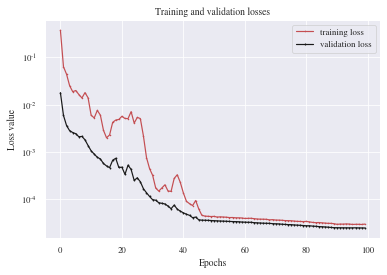

[I 2024-04-28 06:58:08,234] Trial 63 finished with value: 1.5366066284924416e-05 and parameters: {'n_layers': 8, 'hidden_nodes': 193}. Best is trial 63 with value: 1.5366066284924416e-05.


train :  (789, 8)
val :  (98, 8)
test :  (98, 8)
Current test with :


    n_layers: 8
    hidden_nodes: 194



The average loss in epoch 2 is  0.34514333214610815
The average loss in epoch 3 is  0.06151971686631441
The average loss in epoch 4 is  0.03955797191398839
The average loss in epoch 5 is  0.025268832066406805
The average loss in epoch 6 is  0.020834108581766486
The average loss in epoch 7 is  0.01755611877888441
The average loss in epoch 8 is  0.010992507101036608
The average loss in epoch 9 is  0.01480353941830496
The average loss in epoch 10 is  0.014943794929422438
The average loss in epoch 11 is  0.01626789232250303
The average loss in epoch 12 is  0.012556057326340428
The average loss in epoch 13 is  0.00843674443118895
The average loss in epoch 14 is  0.005858715284072484
The average loss in epoch 15 is  0.004996270930860192
The average loss in epoch 16 is  0.004248033568728715
The average loss in epoch 17 is  0.006294156492610152
The average loss in epoch 18 is  0.0064

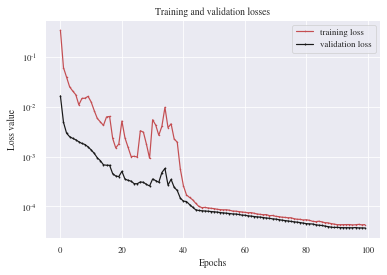

[I 2024-04-28 07:14:11,614] Trial 64 finished with value: 3.071388293965119e-05 and parameters: {'n_layers': 8, 'hidden_nodes': 194}. Best is trial 63 with value: 1.5366066284924416e-05.


train :  (789, 8)
val :  (98, 8)
test :  (98, 8)
Current test with :


    n_layers: 8
    hidden_nodes: 183



The average loss in epoch 2 is  0.42097094530860585
The average loss in epoch 3 is  0.06827451847493649
The average loss in epoch 4 is  0.04667506258313855
The average loss in epoch 5 is  0.029770792461931705
The average loss in epoch 6 is  0.019273976717765134
The average loss in epoch 7 is  0.017652361498524744
The average loss in epoch 8 is  0.017598575407949586
The average loss in epoch 9 is  0.019124848651699722
The average loss in epoch 10 is  0.015823720566307504
The average loss in epoch 11 is  0.014682658909199139
The average loss in epoch 12 is  0.007815282326191664
The average loss in epoch 13 is  0.008304525710021457
The average loss in epoch 14 is  0.006338271118390064
The average loss in epoch 15 is  0.004959970470129822
The average loss in epoch 16 is  0.007498073061772932
The average loss in epoch 17 is  0.010980491798060635
The average loss in epoch 18 is  0.

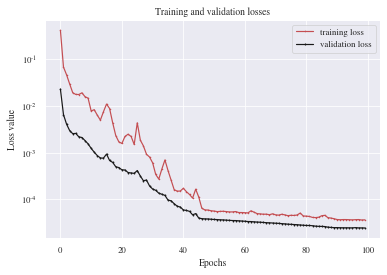

[I 2024-04-28 07:30:00,280] Trial 65 finished with value: 3.14737518354783e-05 and parameters: {'n_layers': 8, 'hidden_nodes': 183}. Best is trial 63 with value: 1.5366066284924416e-05.


train :  (789, 8)
val :  (98, 8)
test :  (98, 8)
Current test with :


    n_layers: 7
    hidden_nodes: 196



The average loss in epoch 2 is  0.36891067679971457
The average loss in epoch 3 is  0.06041564419865608
The average loss in epoch 4 is  0.03981750489523014
The average loss in epoch 5 is  0.02798372406202058
The average loss in epoch 6 is  0.020366137575668592
The average loss in epoch 7 is  0.019630205623495083
The average loss in epoch 8 is  0.012446012755390257
The average loss in epoch 9 is  0.010612848428233216
The average loss in epoch 10 is  0.027490364310021203
The average loss in epoch 11 is  0.014062582224141806
The average loss in epoch 12 is  0.00632720329061461
The average loss in epoch 13 is  0.005796061052630345
The average loss in epoch 14 is  0.005009690425746764
The average loss in epoch 15 is  0.005361664817125226
The average loss in epoch 16 is  0.0031705649356202534
The average loss in epoch 17 is  0.004900920830550604
The average loss in epoch 18 is  0.0

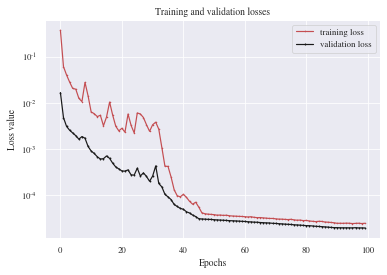

[I 2024-04-28 07:45:09,193] Trial 66 finished with value: 1.5831772016411395e-05 and parameters: {'n_layers': 7, 'hidden_nodes': 196}. Best is trial 63 with value: 1.5366066284924416e-05.


train :  (789, 8)
val :  (98, 8)
test :  (98, 8)
Current test with :


    n_layers: 7
    hidden_nodes: 198



The average loss in epoch 2 is  0.35443476121872663
The average loss in epoch 3 is  0.06385083791489403
The average loss in epoch 4 is  0.04452299792319536
The average loss in epoch 5 is  0.028112846659496427
The average loss in epoch 6 is  0.01995059250233074
The average loss in epoch 7 is  0.016259084998940427
The average loss in epoch 8 is  0.015157924227726957
The average loss in epoch 9 is  0.00925177700507144
The average loss in epoch 10 is  0.014086976530961692
The average loss in epoch 11 is  0.00851653708377853
The average loss in epoch 12 is  0.010190886309525618
The average loss in epoch 13 is  0.011338993771156916
The average loss in epoch 14 is  0.0046264791550735635
The average loss in epoch 15 is  0.00653409546551605
The average loss in epoch 16 is  0.0038173722956950464
The average loss in epoch 17 is  0.0060175144171807915
The average loss in epoch 18 is  0.0

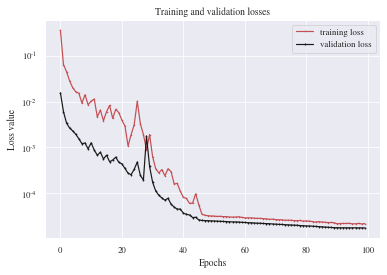

[I 2024-04-28 08:00:35,140] Trial 67 finished with value: 1.3991639018671791e-05 and parameters: {'n_layers': 7, 'hidden_nodes': 198}. Best is trial 67 with value: 1.3991639018671791e-05.


train :  (789, 8)
val :  (98, 8)
test :  (98, 8)
Current test with :


    n_layers: 7
    hidden_nodes: 200



The average loss in epoch 2 is  0.3703761746486028
The average loss in epoch 3 is  0.06372012166927259
The average loss in epoch 4 is  0.0434094270846496
The average loss in epoch 5 is  0.02748715008298556
The average loss in epoch 6 is  0.0190111908596009
The average loss in epoch 7 is  0.016226156944564234
The average loss in epoch 8 is  0.0132482589300101
The average loss in epoch 9 is  0.011994651169516146
The average loss in epoch 10 is  0.010935393278487027
The average loss in epoch 11 is  0.01199485658435151
The average loss in epoch 12 is  0.006088870422293742
The average loss in epoch 13 is  0.008909228005601713
The average loss in epoch 14 is  0.004423039868318786
The average loss in epoch 15 is  0.0036434167996048927
The average loss in epoch 16 is  0.004213036765577272
The average loss in epoch 17 is  0.003763825186373045
The average loss in epoch 18 is  0.0092429

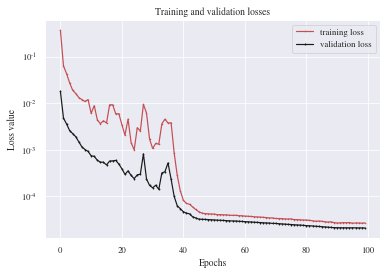

[I 2024-04-28 08:15:45,973] Trial 68 finished with value: 1.466383330085844e-05 and parameters: {'n_layers': 7, 'hidden_nodes': 200}. Best is trial 67 with value: 1.3991639018671791e-05.


train :  (789, 8)
val :  (98, 8)
test :  (98, 8)
Current test with :


    n_layers: 7
    hidden_nodes: 198



The average loss in epoch 2 is  0.35443476121872663
The average loss in epoch 3 is  0.06385083791489403
The average loss in epoch 4 is  0.04452299792319536
The average loss in epoch 5 is  0.028112846659496427
The average loss in epoch 6 is  0.01995059250233074
The average loss in epoch 7 is  0.016259084998940427
The average loss in epoch 8 is  0.015157924227726957
The average loss in epoch 9 is  0.00925177700507144
The average loss in epoch 10 is  0.014086976530961692
The average loss in epoch 11 is  0.00851653708377853
The average loss in epoch 12 is  0.010190886309525618
The average loss in epoch 13 is  0.011338993771156916
The average loss in epoch 14 is  0.0046264791550735635
The average loss in epoch 15 is  0.00653409546551605
The average loss in epoch 16 is  0.0038173722956950464
The average loss in epoch 17 is  0.0060175144171807915
The average loss in epoch 18 is  0.0

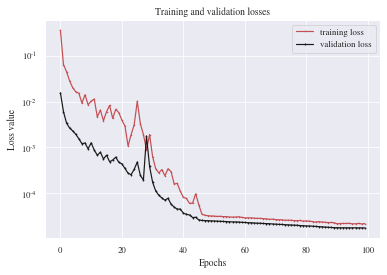

[I 2024-04-28 08:31:10,154] Trial 69 finished with value: 1.3991639018671791e-05 and parameters: {'n_layers': 7, 'hidden_nodes': 198}. Best is trial 67 with value: 1.3991639018671791e-05.


train :  (789, 8)
val :  (98, 8)
test :  (98, 8)
Current test with :


    n_layers: 7
    hidden_nodes: 198



The average loss in epoch 2 is  0.35443476121872663
The average loss in epoch 3 is  0.06385083791489403
The average loss in epoch 4 is  0.04452299792319536
The average loss in epoch 5 is  0.028112846659496427
The average loss in epoch 6 is  0.01995059250233074
The average loss in epoch 7 is  0.016259084998940427
The average loss in epoch 8 is  0.015157924227726957
The average loss in epoch 9 is  0.00925177700507144
The average loss in epoch 10 is  0.014086976530961692
The average loss in epoch 11 is  0.00851653708377853
The average loss in epoch 12 is  0.010190886309525618
The average loss in epoch 13 is  0.011338993771156916
The average loss in epoch 14 is  0.0046264791550735635
The average loss in epoch 15 is  0.00653409546551605
The average loss in epoch 16 is  0.0038173722956950464
The average loss in epoch 17 is  0.0060175144171807915
The average loss in epoch 18 is  0.0

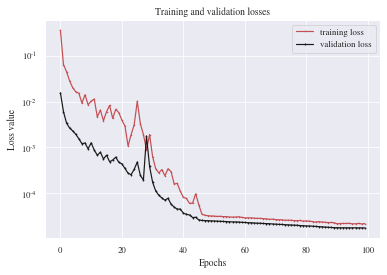

[I 2024-04-28 08:46:41,762] Trial 70 finished with value: 1.3991639018671791e-05 and parameters: {'n_layers': 7, 'hidden_nodes': 198}. Best is trial 67 with value: 1.3991639018671791e-05.


train :  (789, 8)
val :  (98, 8)
test :  (98, 8)
Current test with :


    n_layers: 7
    hidden_nodes: 200



The average loss in epoch 2 is  0.3703761746486028
The average loss in epoch 3 is  0.06372012166927259
The average loss in epoch 4 is  0.0434094270846496
The average loss in epoch 5 is  0.02748715008298556
The average loss in epoch 6 is  0.0190111908596009
The average loss in epoch 7 is  0.016226156944564234
The average loss in epoch 8 is  0.0132482589300101
The average loss in epoch 9 is  0.011994651169516146
The average loss in epoch 10 is  0.010935393278487027
The average loss in epoch 11 is  0.01199485658435151
The average loss in epoch 12 is  0.006088870422293742
The average loss in epoch 13 is  0.008909228005601713
The average loss in epoch 14 is  0.004423039868318786
The average loss in epoch 15 is  0.0036434167996048927
The average loss in epoch 16 is  0.004213036765577272
The average loss in epoch 17 is  0.003763825186373045
The average loss in epoch 18 is  0.0092429

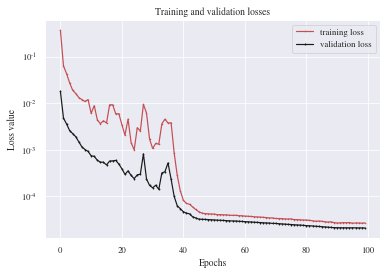

[I 2024-04-28 09:02:03,859] Trial 71 finished with value: 1.466383330085844e-05 and parameters: {'n_layers': 7, 'hidden_nodes': 200}. Best is trial 67 with value: 1.3991639018671791e-05.


train :  (789, 8)
val :  (98, 8)
test :  (98, 8)
Current test with :


    n_layers: 7
    hidden_nodes: 198



The average loss in epoch 2 is  0.35443476121872663
The average loss in epoch 3 is  0.06385083791489403
The average loss in epoch 4 is  0.04452299792319536
The average loss in epoch 5 is  0.028112846659496427
The average loss in epoch 6 is  0.01995059250233074
The average loss in epoch 7 is  0.016259084998940427
The average loss in epoch 8 is  0.015157924227726957
The average loss in epoch 9 is  0.00925177700507144
The average loss in epoch 10 is  0.014086976530961692
The average loss in epoch 11 is  0.00851653708377853
The average loss in epoch 12 is  0.010190886309525618
The average loss in epoch 13 is  0.011338993771156916
The average loss in epoch 14 is  0.0046264791550735635
The average loss in epoch 15 is  0.00653409546551605
The average loss in epoch 16 is  0.0038173722956950464
The average loss in epoch 17 is  0.0060175144171807915
The average loss in epoch 18 is  0.0

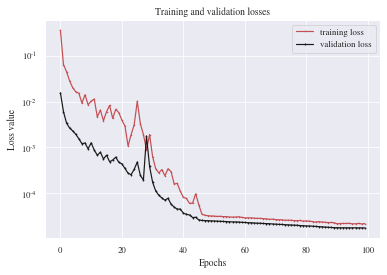

[I 2024-04-28 09:17:40,827] Trial 72 finished with value: 1.3991639018671791e-05 and parameters: {'n_layers': 7, 'hidden_nodes': 198}. Best is trial 67 with value: 1.3991639018671791e-05.


train :  (789, 8)
val :  (98, 8)
test :  (98, 8)
Current test with :


    n_layers: 6
    hidden_nodes: 196



The average loss in epoch 2 is  0.33346491524328786
The average loss in epoch 3 is  0.0622425964102149
The average loss in epoch 4 is  0.040779957470173635
The average loss in epoch 5 is  0.02242063315740476
The average loss in epoch 6 is  0.01725093702164789
The average loss in epoch 7 is  0.016896531412688393
The average loss in epoch 8 is  0.01202251723346611
The average loss in epoch 9 is  0.014022452659749737
The average loss in epoch 10 is  0.01393123452241222
The average loss in epoch 11 is  0.013201013343253484
The average loss in epoch 12 is  0.006707952338426064
The average loss in epoch 13 is  0.008050207116563493
The average loss in epoch 14 is  0.005046289646998048
The average loss in epoch 15 is  0.0039873419639964896
The average loss in epoch 16 is  0.0024638193426653743
The average loss in epoch 17 is  0.0023906338368154443
The average loss in epoch 18 is  0.0

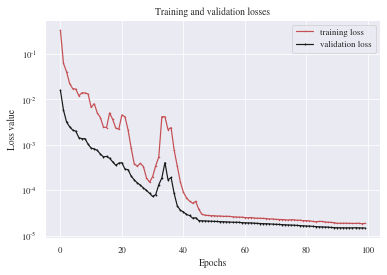

[I 2024-04-28 09:31:29,429] Trial 73 finished with value: 1.3351370798483923e-05 and parameters: {'n_layers': 6, 'hidden_nodes': 196}. Best is trial 73 with value: 1.3351370798483923e-05.


train :  (789, 8)
val :  (98, 8)
test :  (98, 8)
Current test with :


    n_layers: 6
    hidden_nodes: 200



The average loss in epoch 2 is  0.3520700785641869
The average loss in epoch 3 is  0.06300060745949547
The average loss in epoch 4 is  0.045915903989225626
The average loss in epoch 5 is  0.03036335234840711
The average loss in epoch 6 is  0.02329800572867195
The average loss in epoch 7 is  0.018578824315530557
The average loss in epoch 8 is  0.015820630088758964
The average loss in epoch 9 is  0.009225072048138827
The average loss in epoch 10 is  0.024267515322814386
The average loss in epoch 11 is  0.015688753764455516
The average loss in epoch 12 is  0.009505032581121972
The average loss in epoch 13 is  0.009047033711491773
The average loss in epoch 14 is  0.0048793163829638315
The average loss in epoch 15 is  0.008389754531284174
The average loss in epoch 16 is  0.00838067780326431
The average loss in epoch 17 is  0.008976270609612888
The average loss in epoch 18 is  0.00

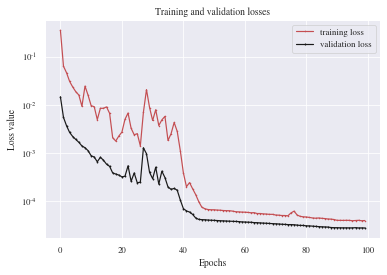

[I 2024-04-28 09:45:20,479] Trial 74 finished with value: 2.752960608745989e-05 and parameters: {'n_layers': 6, 'hidden_nodes': 200}. Best is trial 73 with value: 1.3351370798483923e-05.


train :  (789, 8)
val :  (98, 8)
test :  (98, 8)
Current test with :


    n_layers: 6
    hidden_nodes: 200



The average loss in epoch 2 is  0.3520700785641869
The average loss in epoch 3 is  0.06300060745949547
The average loss in epoch 4 is  0.045915903989225626
The average loss in epoch 5 is  0.03036335234840711
The average loss in epoch 6 is  0.02329800572867195
The average loss in epoch 7 is  0.018578824315530557
The average loss in epoch 8 is  0.015820630088758964
The average loss in epoch 9 is  0.009225072048138827
The average loss in epoch 10 is  0.024267515322814386
The average loss in epoch 11 is  0.015688753764455516
The average loss in epoch 12 is  0.009505032581121972
The average loss in epoch 13 is  0.009047033711491773
The average loss in epoch 14 is  0.0048793163829638315
The average loss in epoch 15 is  0.008389754531284174
The average loss in epoch 16 is  0.00838067780326431
The average loss in epoch 17 is  0.008976270609612888
The average loss in epoch 18 is  0.00

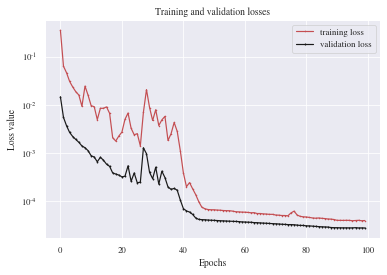

[I 2024-04-28 09:59:14,798] Trial 75 finished with value: 2.752960608745989e-05 and parameters: {'n_layers': 6, 'hidden_nodes': 200}. Best is trial 73 with value: 1.3351370798483923e-05.


train :  (789, 8)
val :  (98, 8)
test :  (98, 8)
Current test with :


    n_layers: 7
    hidden_nodes: 185



The average loss in epoch 2 is  0.4244340509176254
The average loss in epoch 3 is  0.0660870335996151
The average loss in epoch 4 is  0.045368827103326716
The average loss in epoch 5 is  0.02808005743039151
The average loss in epoch 6 is  0.01921395301663627
The average loss in epoch 7 is  0.02018832884884129
The average loss in epoch 8 is  0.012547900783829391
The average loss in epoch 9 is  0.018382123361031216
The average loss in epoch 10 is  0.0167574881343171
The average loss in epoch 11 is  0.013187781480761865
The average loss in epoch 12 is  0.006415638383865978
The average loss in epoch 13 is  0.00630523528282841
The average loss in epoch 14 is  0.005473804931777219
The average loss in epoch 15 is  0.005856020570111771
The average loss in epoch 16 is  0.003056447045916381
The average loss in epoch 17 is  0.0021355438172273957
The average loss in epoch 18 is  0.007503

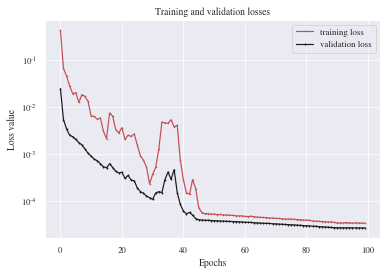

[I 2024-04-28 10:13:31,474] Trial 76 finished with value: 1.960214692964642e-05 and parameters: {'n_layers': 7, 'hidden_nodes': 185}. Best is trial 73 with value: 1.3351370798483923e-05.


train :  (789, 8)
val :  (98, 8)
test :  (98, 8)
Current test with :


    n_layers: 6
    hidden_nodes: 185



The average loss in epoch 2 is  0.3656523876513044
The average loss in epoch 3 is  0.06434628708908956
The average loss in epoch 4 is  0.046366474901636444
The average loss in epoch 5 is  0.029291247793783743
The average loss in epoch 6 is  0.0173284043945993
The average loss in epoch 7 is  0.01627794959737609
The average loss in epoch 8 is  0.01818228924336533
The average loss in epoch 9 is  0.015696028635526698
The average loss in epoch 10 is  0.014057444408535957
The average loss in epoch 11 is  0.013577292130018273
The average loss in epoch 12 is  0.0077945990972997
The average loss in epoch 13 is  0.009410507453139871
The average loss in epoch 14 is  0.00509420337039046
The average loss in epoch 15 is  0.004517313413089141
The average loss in epoch 16 is  0.0033689979997385913
The average loss in epoch 17 is  0.005659627194593971
The average loss in epoch 18 is  0.005503

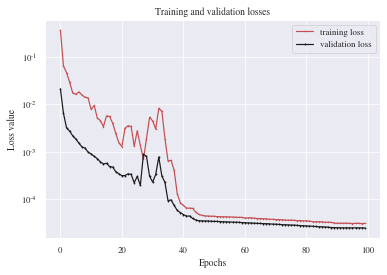

[I 2024-04-28 10:26:27,085] Trial 77 finished with value: 2.0500119275989354e-05 and parameters: {'n_layers': 6, 'hidden_nodes': 185}. Best is trial 73 with value: 1.3351370798483923e-05.


train :  (789, 8)
val :  (98, 8)
test :  (98, 8)
Current test with :


    n_layers: 7
    hidden_nodes: 197



The average loss in epoch 2 is  0.37287187048544485
The average loss in epoch 3 is  0.06173888578390082
The average loss in epoch 4 is  0.04297857110699018
The average loss in epoch 5 is  0.029013647232204676
The average loss in epoch 6 is  0.02285749410899977
The average loss in epoch 7 is  0.017426651747276384
The average loss in epoch 8 is  0.011444854297830412
The average loss in epoch 9 is  0.012581809113423029
The average loss in epoch 10 is  0.01684461433130006
The average loss in epoch 11 is  0.01056424311051766
The average loss in epoch 12 is  0.005375909133969496
The average loss in epoch 13 is  0.0050556661347703384
The average loss in epoch 14 is  0.0038611543520043292
The average loss in epoch 15 is  0.0028445516751768687
The average loss in epoch 16 is  0.00381071997495989
The average loss in epoch 17 is  0.004259962210198864
The average loss in epoch 18 is  0.0

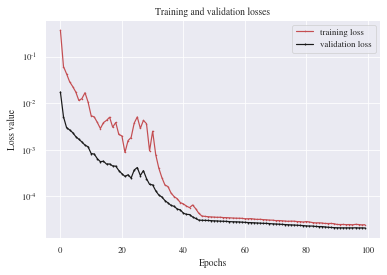

[I 2024-04-28 10:42:04,072] Trial 78 finished with value: 1.8304202162175932e-05 and parameters: {'n_layers': 7, 'hidden_nodes': 197}. Best is trial 73 with value: 1.3351370798483923e-05.


train :  (789, 8)
val :  (98, 8)
test :  (98, 8)
Current test with :


    n_layers: 7
    hidden_nodes: 196



The average loss in epoch 2 is  0.36891067679971457
The average loss in epoch 3 is  0.06041564419865608
The average loss in epoch 4 is  0.03981750489523014
The average loss in epoch 5 is  0.02798372406202058
The average loss in epoch 6 is  0.020366137575668592
The average loss in epoch 7 is  0.019630205623495083
The average loss in epoch 8 is  0.012446012755390257
The average loss in epoch 9 is  0.010612848428233216
The average loss in epoch 10 is  0.027490364310021203
The average loss in epoch 11 is  0.014062582224141806
The average loss in epoch 12 is  0.00632720329061461
The average loss in epoch 13 is  0.005796061052630345
The average loss in epoch 14 is  0.005009690425746764
The average loss in epoch 15 is  0.005361664817125226
The average loss in epoch 16 is  0.0031705649356202534
The average loss in epoch 17 is  0.004900920830550604
The average loss in epoch 18 is  0.0

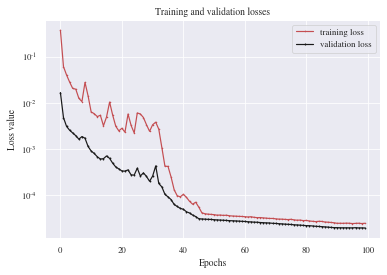

[I 2024-04-28 10:57:17,460] Trial 79 finished with value: 1.5831772016411395e-05 and parameters: {'n_layers': 7, 'hidden_nodes': 196}. Best is trial 73 with value: 1.3351370798483923e-05.


train :  (789, 8)
val :  (98, 8)
test :  (98, 8)
Current test with :


    n_layers: 7
    hidden_nodes: 176



The average loss in epoch 2 is  0.3799527181933324
The average loss in epoch 3 is  0.06349454276884596
The average loss in epoch 4 is  0.04570205230265856
The average loss in epoch 5 is  0.035818859934806824
The average loss in epoch 6 is  0.02428322813163201
The average loss in epoch 7 is  0.018417776756299038
The average loss in epoch 8 is  0.014687288707743088
The average loss in epoch 9 is  0.012610709139456352
The average loss in epoch 10 is  0.013159605325199664
The average loss in epoch 11 is  0.017021238105371594
The average loss in epoch 12 is  0.007815755321644247
The average loss in epoch 13 is  0.00972505146637559
The average loss in epoch 14 is  0.006205053146307667
The average loss in epoch 15 is  0.0053407373585893465
The average loss in epoch 16 is  0.008312608658646544
The average loss in epoch 17 is  0.005896180169656873
The average loss in epoch 18 is  0.00

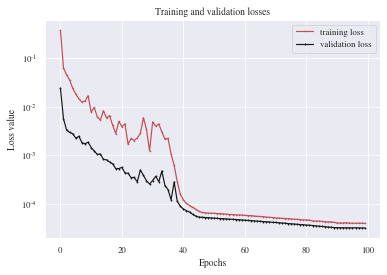

[I 2024-04-28 11:10:30,021] Trial 80 finished with value: 2.0565254837785267e-05 and parameters: {'n_layers': 7, 'hidden_nodes': 176}. Best is trial 73 with value: 1.3351370798483923e-05.


train :  (789, 8)
val :  (98, 8)
test :  (98, 8)
Current test with :


    n_layers: 7
    hidden_nodes: 196



The average loss in epoch 2 is  0.36891067679971457
The average loss in epoch 3 is  0.06041564419865608
The average loss in epoch 4 is  0.03981750489523014
The average loss in epoch 5 is  0.02798372406202058
The average loss in epoch 6 is  0.020366137575668592
The average loss in epoch 7 is  0.019630205623495083
The average loss in epoch 8 is  0.012446012755390257
The average loss in epoch 9 is  0.010612848428233216
The average loss in epoch 10 is  0.027490364310021203
The average loss in epoch 11 is  0.014062582224141806
The average loss in epoch 12 is  0.00632720329061461
The average loss in epoch 13 is  0.005796061052630345
The average loss in epoch 14 is  0.005009690425746764
The average loss in epoch 15 is  0.005361664817125226
The average loss in epoch 16 is  0.0031705649356202534
The average loss in epoch 17 is  0.004900920830550604
The average loss in epoch 18 is  0.0

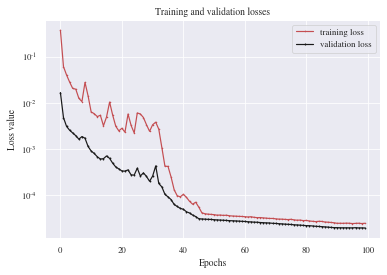

[I 2024-04-28 11:25:59,086] Trial 81 finished with value: 1.5831772016411395e-05 and parameters: {'n_layers': 7, 'hidden_nodes': 196}. Best is trial 73 with value: 1.3351370798483923e-05.


train :  (789, 8)
val :  (98, 8)
test :  (98, 8)
Current test with :


    n_layers: 7
    hidden_nodes: 200



The average loss in epoch 2 is  0.3703761746486028
The average loss in epoch 3 is  0.06372012166927259
The average loss in epoch 4 is  0.0434094270846496
The average loss in epoch 5 is  0.02748715008298556
The average loss in epoch 6 is  0.0190111908596009
The average loss in epoch 7 is  0.016226156944564234
The average loss in epoch 8 is  0.0132482589300101
The average loss in epoch 9 is  0.011994651169516146
The average loss in epoch 10 is  0.010935393278487027
The average loss in epoch 11 is  0.01199485658435151
The average loss in epoch 12 is  0.006088870422293742
The average loss in epoch 13 is  0.008909228005601713
The average loss in epoch 14 is  0.004423039868318786
The average loss in epoch 15 is  0.0036434167996048927
The average loss in epoch 16 is  0.004213036765577272
The average loss in epoch 17 is  0.003763825186373045
The average loss in epoch 18 is  0.0092429

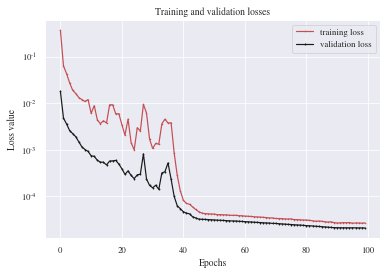

[I 2024-04-28 11:41:22,072] Trial 82 finished with value: 1.466383330085844e-05 and parameters: {'n_layers': 7, 'hidden_nodes': 200}. Best is trial 73 with value: 1.3351370798483923e-05.


train :  (789, 8)
val :  (98, 8)
test :  (98, 8)
Current test with :


    n_layers: 6
    hidden_nodes: 185



The average loss in epoch 2 is  0.3656523876513044
The average loss in epoch 3 is  0.06434628708908956
The average loss in epoch 4 is  0.046366474901636444
The average loss in epoch 5 is  0.029291247793783743
The average loss in epoch 6 is  0.0173284043945993
The average loss in epoch 7 is  0.01627794959737609
The average loss in epoch 8 is  0.01818228924336533
The average loss in epoch 9 is  0.015696028635526698
The average loss in epoch 10 is  0.014057444408535957
The average loss in epoch 11 is  0.013577292130018273
The average loss in epoch 12 is  0.0077945990972997
The average loss in epoch 13 is  0.009410507453139871
The average loss in epoch 14 is  0.00509420337039046
The average loss in epoch 15 is  0.004517313413089141
The average loss in epoch 16 is  0.0033689979997385913
The average loss in epoch 17 is  0.005659627194593971
The average loss in epoch 18 is  0.005503

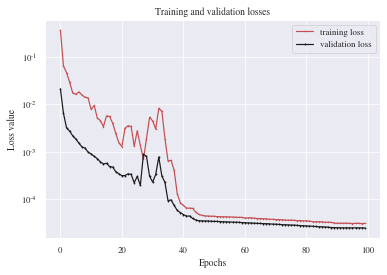

[I 2024-04-28 11:54:51,969] Trial 83 finished with value: 2.0500119275989354e-05 and parameters: {'n_layers': 6, 'hidden_nodes': 185}. Best is trial 73 with value: 1.3351370798483923e-05.


train :  (789, 8)
val :  (98, 8)
test :  (98, 8)
Current test with :


    n_layers: 7
    hidden_nodes: 200



The average loss in epoch 2 is  0.3703761746486028
The average loss in epoch 3 is  0.06372012166927259
The average loss in epoch 4 is  0.0434094270846496
The average loss in epoch 5 is  0.02748715008298556
The average loss in epoch 6 is  0.0190111908596009
The average loss in epoch 7 is  0.016226156944564234
The average loss in epoch 8 is  0.0132482589300101
The average loss in epoch 9 is  0.011994651169516146
The average loss in epoch 10 is  0.010935393278487027
The average loss in epoch 11 is  0.01199485658435151
The average loss in epoch 12 is  0.006088870422293742
The average loss in epoch 13 is  0.008909228005601713
The average loss in epoch 14 is  0.004423039868318786
The average loss in epoch 15 is  0.0036434167996048927
The average loss in epoch 16 is  0.004213036765577272
The average loss in epoch 17 is  0.003763825186373045
The average loss in epoch 18 is  0.0092429

In [ ]:
optuna_study = input("Do you want to do hyperparameter test? Type yes or no ")
params = {}
if optuna_study=="yes":
    optuna_study = True
else:
    optuna_study = False
if optuna_study:
    study = optuna.create_study(direction="minimize",study_name="Euler Elastica")
    study.optimize(objective, n_trials=300)
    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    params = study.best_params

In [ ]:
study.best_params
params = study.best_params

In [ ]:
torch.manual_seed(1)
np.random.seed(1)

In [ ]:
manual_input = False
if params=={}:
    # We can input them manually by uncommenting the lines below
    if manual_input:
        print("No parameters have been specified. Let's input them:\n\n")
        normalize = input("Normalize is True or False? ")=="True"
        networkarch = int(input("Network architecture: Type 0 for MULT, 1 for ResNet, 2 for MLP: "))
        act = input("What activation function to use? Choose among 'sin', 'sigmoid', 'swish', 'tanh': ")
        nlayers = int(input("How many layers do you want the network to have? "))
        hidden_nodes = int(input("How many hidden nodes do you want the network to have? "))
        lr = float(input("What learning rate do you want to use? "))
        params = {"normalize": normalize,
                "act": act,
                "n_layers":nlayers,
                "hidden_nodes":hidden_nodes,
                "networkarch":networkarch,
                "lr":lr}
    else:
    # or we can use the combinations found by Optuna that yield the best results for the mentioned datacases
        params = hyperparams(percentage_train)

In [ ]:
print(f'The hyperparameters yelding the best results for this case are: {params}')

In [ ]:
def define_best_model():
    normalize = True #params["normalize"]
    act = 'tanh'#params["act"]
    nlayers = params["n_layers"]
    hidden_nodes = params["hidden_nodes"]

#     if params["networkarch"] == 0:
#         is_mult = True
#         is_res = False
#     elif params["networkarch"] == 1:
#        is_mult = False
#        is_res = True
#     else:
#         is_mult = False
#         is_res = False

    is_mult = True
    is_res = False
    model = approximate_curve(normalize, act, nlayers, hidden_nodes, correct_functional=False, is_res=is_res, is_mult=is_mult, both=False)

    return model

In [ ]:
model = define_best_model()
model.to(device);

In [ ]:
TrainMode = input("Train Mode True or False? Type 0 for False and 1 for True: ")
TrainMode = int(TrainMode)
if TrainMode == 0:
    TrainMode = False
else:
    TrainMode = True
TrainMode

In [ ]:
weight_decay = 0
lr = 1e-3 #params["lr"]
optimizer = torch.optim.Adam(model.parameters(),lr=lr,weight_decay=weight_decay)

criterion = nn.MSELoss()

_, _, _, _, _, _, _, _, _, trainloader, testloader, valloader = getDataLoaders(batch_size, number_elements,number_samples_train, number_samples_test,trajectories_train, test_traj, percentage_train)
model.to(device);

if TrainMode:
    loss = trainModel(number_elements,device,model,criterion,optimizer,epochs,trainloader,valloader, train_with_tangents=False,pde_regularisation=False,soft_bcs_imposition=False)
    if percentage_train == 0.9:
        torch.save(model.state_dict(), 'TrainedModels/BothEnds0.9data.pt')
    elif percentage_train == 0.4:
        torch.save(model.state_dict(), 'TrainedModels/BothEnds0.4data.pt')
    elif percentage_train == 0.2:
        torch.save(model.state_dict(), 'TrainedModels/BothEnds0.2data.pt')
    else:
        torch.save(model.state_dict(), 'TrainedModels/BothEnds0.1data.pt')
else:
    if percentage_train == 0.9:
        pretrained_dict = torch.load(f'TrainedModels/BothEnds0.9data.pt',map_location=device)
    elif percentage_train == 0.4:
        pretrained_dict = torch.load(f'TrainedModels/BothEnds0.4data.pt',map_location=device)
    elif percentage_train == 0.2:
        pretrained_dict = torch.load(f'TrainedModels/BothEnds0.2data.pt',map_location=device)
    else:
        pretrained_dict = torch.load(f'TrainedModels/BothEnds0.1data.pt',map_location=device)
    model.load_state_dict(pretrained_dict)


In [ ]:
# printing the accuracies and plotting the results

model.eval();
res,res_derivative = plotTestResults(model,device,number_elements,number_components,x_train,x_test,y_train,y_test, num_nodes, percentage_train)